# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [25]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

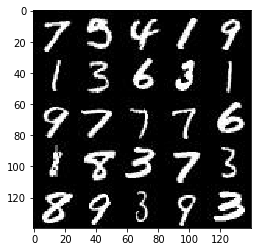

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

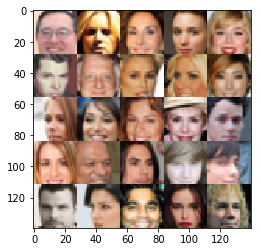

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [29]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        conv1 = tf.layers.conv2d(images, 32, 3, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(lrelu1, 64, 3, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        drop = tf.layers.dropout(lrelu2, rate=0.2)

        conv3 = tf.layers.conv2d(drop, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        features = tf.reduce_mean(lrelu3, (1, 2))        
        logits = tf.layers.dense(features, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.5)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #_, img_width, img_height, img_channels = data_shape
    
    tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 1.2907... Generator Loss: 0.7815 Sum Loss: 2.0722
Epoch 1/10... Discriminator Loss: 1.3170... Generator Loss: 0.8356 Sum Loss: 2.1526
Epoch 1/10... Discriminator Loss: 1.3258... Generator Loss: 0.8086 Sum Loss: 2.1344
Epoch 1/10... Discriminator Loss: 1.3386... Generator Loss: 0.7936 Sum Loss: 2.1322
Epoch 1/10... Discriminator Loss: 1.3478... Generator Loss: 0.8086 Sum Loss: 2.1564
Epoch 1/10... Discriminator Loss: 1.3378... Generator Loss: 0.8037 Sum Loss: 2.1416
Epoch 1/10... Discriminator Loss: 1.3336... Generator Loss: 0.8093 Sum Loss: 2.1429
Epoch 1/10... Discriminator Loss: 1.3518... Generator Loss: 0.8109 Sum Loss: 2.1627
Epoch 1/10... Discriminator Loss: 1.3279... Generator Loss: 0.8249 Sum Loss: 2.1528
Epoch 1/10... Discriminator Loss: 1.3348... Generator Loss: 0.8034 Sum Loss: 2.1383


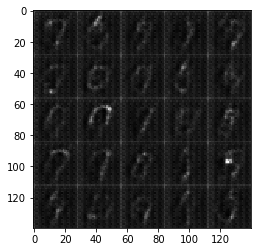

Epoch 1/10... Discriminator Loss: 1.3487... Generator Loss: 0.7875 Sum Loss: 2.1362
Epoch 1/10... Discriminator Loss: 1.3389... Generator Loss: 0.7846 Sum Loss: 2.1235
Epoch 1/10... Discriminator Loss: 1.3360... Generator Loss: 0.7970 Sum Loss: 2.1330
Epoch 1/10... Discriminator Loss: 1.3385... Generator Loss: 0.7890 Sum Loss: 2.1275
Epoch 1/10... Discriminator Loss: 1.3404... Generator Loss: 0.7919 Sum Loss: 2.1323
Epoch 1/10... Discriminator Loss: 1.3408... Generator Loss: 0.8039 Sum Loss: 2.1447
Epoch 1/10... Discriminator Loss: 1.3548... Generator Loss: 0.8563 Sum Loss: 2.2111
Epoch 1/10... Discriminator Loss: 1.3523... Generator Loss: 0.8426 Sum Loss: 2.1949
Epoch 1/10... Discriminator Loss: 1.3393... Generator Loss: 0.7901 Sum Loss: 2.1294
Epoch 1/10... Discriminator Loss: 1.3175... Generator Loss: 0.8111 Sum Loss: 2.1286


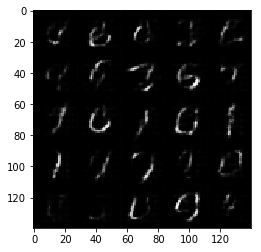

Epoch 1/10... Discriminator Loss: 1.3378... Generator Loss: 0.7935 Sum Loss: 2.1314
Epoch 1/10... Discriminator Loss: 1.3337... Generator Loss: 0.7843 Sum Loss: 2.1180
Epoch 1/10... Discriminator Loss: 1.3497... Generator Loss: 0.7551 Sum Loss: 2.1048
Epoch 1/10... Discriminator Loss: 1.3298... Generator Loss: 0.8194 Sum Loss: 2.1492
Epoch 2/10... Discriminator Loss: 1.3240... Generator Loss: 0.8029 Sum Loss: 2.1269
Epoch 2/10... Discriminator Loss: 1.3358... Generator Loss: 0.8054 Sum Loss: 2.1412
Epoch 2/10... Discriminator Loss: 1.3221... Generator Loss: 0.8466 Sum Loss: 2.1688
Epoch 2/10... Discriminator Loss: 1.3302... Generator Loss: 0.8405 Sum Loss: 2.1707
Epoch 2/10... Discriminator Loss: 1.3102... Generator Loss: 0.8027 Sum Loss: 2.1128
Epoch 2/10... Discriminator Loss: 1.3295... Generator Loss: 0.7848 Sum Loss: 2.1143


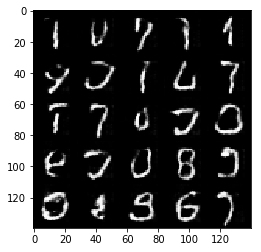

Epoch 2/10... Discriminator Loss: 1.3324... Generator Loss: 0.8096 Sum Loss: 2.1421
Epoch 2/10... Discriminator Loss: 1.3291... Generator Loss: 0.8472 Sum Loss: 2.1763
Epoch 2/10... Discriminator Loss: 1.3166... Generator Loss: 0.8343 Sum Loss: 2.1508
Epoch 2/10... Discriminator Loss: 1.3102... Generator Loss: 0.8016 Sum Loss: 2.1117
Epoch 2/10... Discriminator Loss: 1.3273... Generator Loss: 0.8096 Sum Loss: 2.1369
Epoch 2/10... Discriminator Loss: 1.3043... Generator Loss: 0.8243 Sum Loss: 2.1287
Epoch 2/10... Discriminator Loss: 1.2962... Generator Loss: 0.7593 Sum Loss: 2.0556
Epoch 2/10... Discriminator Loss: 1.2825... Generator Loss: 0.8486 Sum Loss: 2.1311
Epoch 2/10... Discriminator Loss: 1.3108... Generator Loss: 0.7647 Sum Loss: 2.0755
Epoch 2/10... Discriminator Loss: 1.2963... Generator Loss: 0.8144 Sum Loss: 2.1107


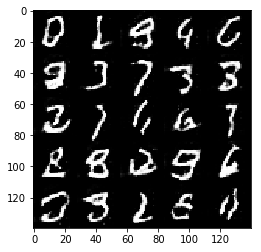

Epoch 2/10... Discriminator Loss: 1.3105... Generator Loss: 0.8071 Sum Loss: 2.1176
Epoch 2/10... Discriminator Loss: 1.2464... Generator Loss: 0.8448 Sum Loss: 2.0912
Epoch 2/10... Discriminator Loss: 1.2778... Generator Loss: 0.8267 Sum Loss: 2.1045
Epoch 2/10... Discriminator Loss: 1.2510... Generator Loss: 0.7879 Sum Loss: 2.0390
Epoch 2/10... Discriminator Loss: 1.2861... Generator Loss: 0.8560 Sum Loss: 2.1421
Epoch 2/10... Discriminator Loss: 1.2874... Generator Loss: 0.8314 Sum Loss: 2.1188
Epoch 2/10... Discriminator Loss: 1.2583... Generator Loss: 0.9252 Sum Loss: 2.1835
Epoch 2/10... Discriminator Loss: 1.2505... Generator Loss: 0.8702 Sum Loss: 2.1207
Epoch 3/10... Discriminator Loss: 1.2821... Generator Loss: 0.8042 Sum Loss: 2.0863
Epoch 3/10... Discriminator Loss: 1.2078... Generator Loss: 0.8782 Sum Loss: 2.0861


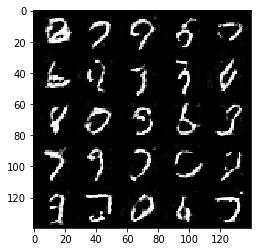

Epoch 3/10... Discriminator Loss: 1.2494... Generator Loss: 0.8107 Sum Loss: 2.0602
Epoch 3/10... Discriminator Loss: 1.1939... Generator Loss: 0.8654 Sum Loss: 2.0593
Epoch 3/10... Discriminator Loss: 1.2531... Generator Loss: 0.8671 Sum Loss: 2.1203
Epoch 3/10... Discriminator Loss: 1.2377... Generator Loss: 0.8088 Sum Loss: 2.0465
Epoch 3/10... Discriminator Loss: 1.2744... Generator Loss: 0.8696 Sum Loss: 2.1440
Epoch 3/10... Discriminator Loss: 1.2501... Generator Loss: 0.8368 Sum Loss: 2.0869
Epoch 3/10... Discriminator Loss: 1.1729... Generator Loss: 0.9648 Sum Loss: 2.1377
Epoch 3/10... Discriminator Loss: 1.1783... Generator Loss: 0.8293 Sum Loss: 2.0076
Epoch 3/10... Discriminator Loss: 1.1415... Generator Loss: 0.9368 Sum Loss: 2.0783
Epoch 3/10... Discriminator Loss: 1.2197... Generator Loss: 0.9394 Sum Loss: 2.1591


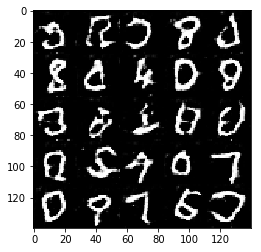

Epoch 3/10... Discriminator Loss: 1.1635... Generator Loss: 0.9156 Sum Loss: 2.0791
Epoch 3/10... Discriminator Loss: 1.1772... Generator Loss: 0.8302 Sum Loss: 2.0074
Epoch 3/10... Discriminator Loss: 1.1637... Generator Loss: 0.9050 Sum Loss: 2.0687
Epoch 3/10... Discriminator Loss: 1.1476... Generator Loss: 0.9007 Sum Loss: 2.0482
Epoch 3/10... Discriminator Loss: 1.1477... Generator Loss: 0.9765 Sum Loss: 2.1242
Epoch 3/10... Discriminator Loss: 1.2130... Generator Loss: 0.8488 Sum Loss: 2.0618
Epoch 3/10... Discriminator Loss: 1.1621... Generator Loss: 0.9113 Sum Loss: 2.0734
Epoch 3/10... Discriminator Loss: 1.1544... Generator Loss: 0.9712 Sum Loss: 2.1256
Epoch 3/10... Discriminator Loss: 1.2871... Generator Loss: 0.6923 Sum Loss: 1.9794
Epoch 3/10... Discriminator Loss: 1.1477... Generator Loss: 0.9251 Sum Loss: 2.0728


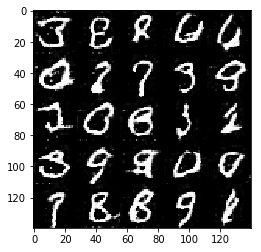

Epoch 3/10... Discriminator Loss: 1.1286... Generator Loss: 0.9575 Sum Loss: 2.0862
Epoch 3/10... Discriminator Loss: 1.1575... Generator Loss: 0.8478 Sum Loss: 2.0053
Epoch 4/10... Discriminator Loss: 1.1857... Generator Loss: 0.8597 Sum Loss: 2.0453
Epoch 4/10... Discriminator Loss: 1.1135... Generator Loss: 0.9765 Sum Loss: 2.0900
Epoch 4/10... Discriminator Loss: 1.1818... Generator Loss: 0.8367 Sum Loss: 2.0185
Epoch 4/10... Discriminator Loss: 1.1950... Generator Loss: 0.8167 Sum Loss: 2.0117
Epoch 4/10... Discriminator Loss: 1.0778... Generator Loss: 0.9601 Sum Loss: 2.0379
Epoch 4/10... Discriminator Loss: 1.1326... Generator Loss: 0.9077 Sum Loss: 2.0403
Epoch 4/10... Discriminator Loss: 1.1320... Generator Loss: 0.8677 Sum Loss: 1.9997
Epoch 4/10... Discriminator Loss: 1.1292... Generator Loss: 0.8589 Sum Loss: 1.9881


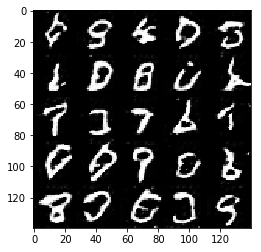

Epoch 4/10... Discriminator Loss: 1.1920... Generator Loss: 0.9562 Sum Loss: 2.1481
Epoch 4/10... Discriminator Loss: 1.1553... Generator Loss: 0.8992 Sum Loss: 2.0545
Epoch 4/10... Discriminator Loss: 1.1324... Generator Loss: 0.8513 Sum Loss: 1.9836
Epoch 4/10... Discriminator Loss: 1.0898... Generator Loss: 0.9531 Sum Loss: 2.0429
Epoch 4/10... Discriminator Loss: 1.1709... Generator Loss: 1.0212 Sum Loss: 2.1921
Epoch 4/10... Discriminator Loss: 1.0544... Generator Loss: 1.0145 Sum Loss: 2.0689
Epoch 4/10... Discriminator Loss: 1.1152... Generator Loss: 0.9520 Sum Loss: 2.0671
Epoch 4/10... Discriminator Loss: 1.0355... Generator Loss: 0.9810 Sum Loss: 2.0165
Epoch 4/10... Discriminator Loss: 1.1246... Generator Loss: 1.0310 Sum Loss: 2.1556
Epoch 4/10... Discriminator Loss: 1.1755... Generator Loss: 0.9817 Sum Loss: 2.1572


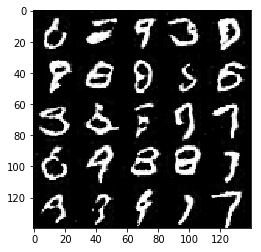

Epoch 4/10... Discriminator Loss: 1.0464... Generator Loss: 1.0097 Sum Loss: 2.0561
Epoch 4/10... Discriminator Loss: 1.0372... Generator Loss: 1.0161 Sum Loss: 2.0533
Epoch 4/10... Discriminator Loss: 1.0971... Generator Loss: 0.9580 Sum Loss: 2.0551
Epoch 4/10... Discriminator Loss: 1.0477... Generator Loss: 1.0612 Sum Loss: 2.1089
Epoch 4/10... Discriminator Loss: 1.1149... Generator Loss: 0.9071 Sum Loss: 2.0221
Epoch 4/10... Discriminator Loss: 1.1643... Generator Loss: 0.8896 Sum Loss: 2.0539
Epoch 5/10... Discriminator Loss: 1.0566... Generator Loss: 1.0040 Sum Loss: 2.0606
Epoch 5/10... Discriminator Loss: 1.1064... Generator Loss: 0.9207 Sum Loss: 2.0271
Epoch 5/10... Discriminator Loss: 1.1063... Generator Loss: 0.9384 Sum Loss: 2.0448
Epoch 5/10... Discriminator Loss: 1.1382... Generator Loss: 1.0511 Sum Loss: 2.1893


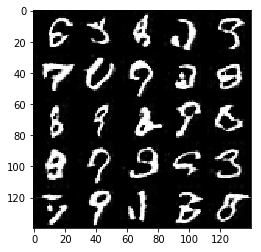

Epoch 5/10... Discriminator Loss: 1.1387... Generator Loss: 0.9087 Sum Loss: 2.0473
Epoch 5/10... Discriminator Loss: 1.1272... Generator Loss: 0.9955 Sum Loss: 2.1227
Epoch 5/10... Discriminator Loss: 1.0549... Generator Loss: 0.9525 Sum Loss: 2.0074
Epoch 5/10... Discriminator Loss: 1.1430... Generator Loss: 1.0185 Sum Loss: 2.1615
Epoch 5/10... Discriminator Loss: 1.1259... Generator Loss: 0.9879 Sum Loss: 2.1139
Epoch 5/10... Discriminator Loss: 1.0677... Generator Loss: 0.9374 Sum Loss: 2.0051
Epoch 5/10... Discriminator Loss: 1.1506... Generator Loss: 1.0421 Sum Loss: 2.1927
Epoch 5/10... Discriminator Loss: 1.3036... Generator Loss: 0.6226 Sum Loss: 1.9261
Epoch 5/10... Discriminator Loss: 1.1304... Generator Loss: 0.9397 Sum Loss: 2.0701
Epoch 5/10... Discriminator Loss: 1.0890... Generator Loss: 0.9761 Sum Loss: 2.0651


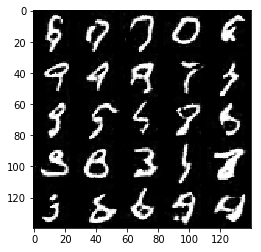

Epoch 5/10... Discriminator Loss: 1.1100... Generator Loss: 1.0815 Sum Loss: 2.1916
Epoch 5/10... Discriminator Loss: 1.0943... Generator Loss: 0.9934 Sum Loss: 2.0877
Epoch 5/10... Discriminator Loss: 1.0998... Generator Loss: 1.2708 Sum Loss: 2.3707
Epoch 5/10... Discriminator Loss: 1.1292... Generator Loss: 0.8849 Sum Loss: 2.0141
Epoch 5/10... Discriminator Loss: 1.0729... Generator Loss: 0.9188 Sum Loss: 1.9917
Epoch 5/10... Discriminator Loss: 1.1015... Generator Loss: 0.9555 Sum Loss: 2.0570
Epoch 5/10... Discriminator Loss: 1.1437... Generator Loss: 0.9925 Sum Loss: 2.1361
Epoch 5/10... Discriminator Loss: 1.1545... Generator Loss: 0.8476 Sum Loss: 2.0021
Epoch 5/10... Discriminator Loss: 1.0602... Generator Loss: 1.0693 Sum Loss: 2.1295
Epoch 5/10... Discriminator Loss: 1.0902... Generator Loss: 1.0478 Sum Loss: 2.1380


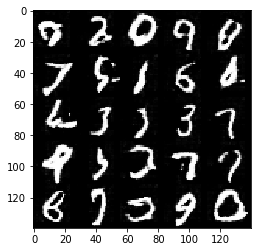

Epoch 6/10... Discriminator Loss: 1.1796... Generator Loss: 0.8419 Sum Loss: 2.0215
Epoch 6/10... Discriminator Loss: 1.1213... Generator Loss: 0.8862 Sum Loss: 2.0075
Epoch 6/10... Discriminator Loss: 1.1159... Generator Loss: 0.8667 Sum Loss: 1.9826
Epoch 6/10... Discriminator Loss: 1.1580... Generator Loss: 0.8527 Sum Loss: 2.0107
Epoch 6/10... Discriminator Loss: 1.0517... Generator Loss: 1.1151 Sum Loss: 2.1668
Epoch 6/10... Discriminator Loss: 1.2414... Generator Loss: 0.8634 Sum Loss: 2.1047
Epoch 6/10... Discriminator Loss: 1.1354... Generator Loss: 0.9673 Sum Loss: 2.1026
Epoch 6/10... Discriminator Loss: 1.0494... Generator Loss: 1.1287 Sum Loss: 2.1782
Epoch 6/10... Discriminator Loss: 1.0624... Generator Loss: 0.9724 Sum Loss: 2.0349
Epoch 6/10... Discriminator Loss: 1.1350... Generator Loss: 1.0384 Sum Loss: 2.1734


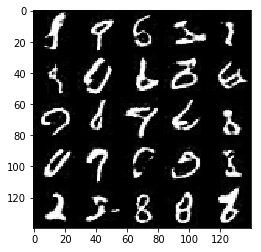

Epoch 6/10... Discriminator Loss: 1.0841... Generator Loss: 0.9764 Sum Loss: 2.0605
Epoch 6/10... Discriminator Loss: 1.1264... Generator Loss: 0.9227 Sum Loss: 2.0491
Epoch 6/10... Discriminator Loss: 1.1593... Generator Loss: 0.9089 Sum Loss: 2.0682
Epoch 6/10... Discriminator Loss: 1.1164... Generator Loss: 0.8898 Sum Loss: 2.0063
Epoch 6/10... Discriminator Loss: 1.0862... Generator Loss: 0.8994 Sum Loss: 1.9856
Epoch 6/10... Discriminator Loss: 1.0914... Generator Loss: 0.9653 Sum Loss: 2.0568
Epoch 6/10... Discriminator Loss: 1.4226... Generator Loss: 1.2222 Sum Loss: 2.6448
Epoch 6/10... Discriminator Loss: 1.0743... Generator Loss: 0.9308 Sum Loss: 2.0051
Epoch 6/10... Discriminator Loss: 1.1506... Generator Loss: 0.9784 Sum Loss: 2.1290
Epoch 6/10... Discriminator Loss: 1.1152... Generator Loss: 0.8868 Sum Loss: 2.0020


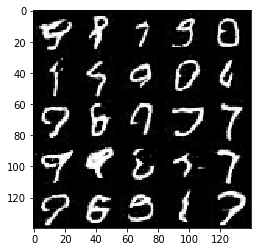

Epoch 6/10... Discriminator Loss: 1.0528... Generator Loss: 1.0511 Sum Loss: 2.1040
Epoch 6/10... Discriminator Loss: 1.1402... Generator Loss: 0.9138 Sum Loss: 2.0540
Epoch 6/10... Discriminator Loss: 1.1515... Generator Loss: 0.9468 Sum Loss: 2.0983
Epoch 6/10... Discriminator Loss: 1.0753... Generator Loss: 0.9130 Sum Loss: 1.9883
Epoch 7/10... Discriminator Loss: 1.0877... Generator Loss: 0.9403 Sum Loss: 2.0280
Epoch 7/10... Discriminator Loss: 1.1016... Generator Loss: 0.9975 Sum Loss: 2.0992
Epoch 7/10... Discriminator Loss: 1.1247... Generator Loss: 0.9837 Sum Loss: 2.1084
Epoch 7/10... Discriminator Loss: 1.0956... Generator Loss: 0.8566 Sum Loss: 1.9523
Epoch 7/10... Discriminator Loss: 1.1014... Generator Loss: 1.0421 Sum Loss: 2.1435
Epoch 7/10... Discriminator Loss: 1.1334... Generator Loss: 1.3138 Sum Loss: 2.4472


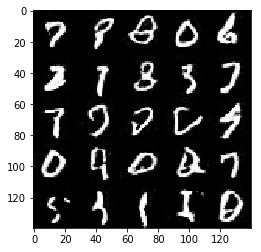

Epoch 7/10... Discriminator Loss: 1.0589... Generator Loss: 1.0037 Sum Loss: 2.0626
Epoch 7/10... Discriminator Loss: 1.0746... Generator Loss: 1.0335 Sum Loss: 2.1081
Epoch 7/10... Discriminator Loss: 1.0837... Generator Loss: 0.9438 Sum Loss: 2.0275
Epoch 7/10... Discriminator Loss: 0.9927... Generator Loss: 1.1362 Sum Loss: 2.1289
Epoch 7/10... Discriminator Loss: 1.1020... Generator Loss: 0.8580 Sum Loss: 1.9601
Epoch 7/10... Discriminator Loss: 1.0269... Generator Loss: 1.0873 Sum Loss: 2.1142
Epoch 7/10... Discriminator Loss: 1.1566... Generator Loss: 0.9743 Sum Loss: 2.1309
Epoch 7/10... Discriminator Loss: 1.0564... Generator Loss: 0.8574 Sum Loss: 1.9138
Epoch 7/10... Discriminator Loss: 1.0315... Generator Loss: 1.0139 Sum Loss: 2.0455
Epoch 7/10... Discriminator Loss: 0.9983... Generator Loss: 0.9679 Sum Loss: 1.9661


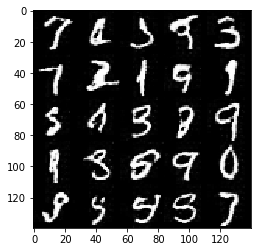

Epoch 7/10... Discriminator Loss: 1.0169... Generator Loss: 0.9036 Sum Loss: 1.9205
Epoch 7/10... Discriminator Loss: 1.2326... Generator Loss: 0.8307 Sum Loss: 2.0633
Epoch 7/10... Discriminator Loss: 1.0842... Generator Loss: 0.9789 Sum Loss: 2.0631
Epoch 7/10... Discriminator Loss: 1.1987... Generator Loss: 0.7434 Sum Loss: 1.9421
Epoch 7/10... Discriminator Loss: 1.0072... Generator Loss: 1.0763 Sum Loss: 2.0835
Epoch 7/10... Discriminator Loss: 1.0707... Generator Loss: 1.0579 Sum Loss: 2.1286
Epoch 7/10... Discriminator Loss: 1.1602... Generator Loss: 0.8512 Sum Loss: 2.0115
Epoch 7/10... Discriminator Loss: 1.0453... Generator Loss: 1.1404 Sum Loss: 2.1857
Epoch 8/10... Discriminator Loss: 1.0714... Generator Loss: 1.0001 Sum Loss: 2.0715
Epoch 8/10... Discriminator Loss: 1.0681... Generator Loss: 0.8696 Sum Loss: 1.9378


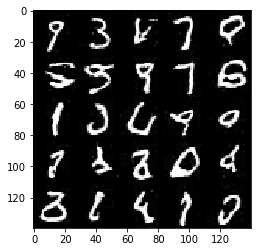

Epoch 8/10... Discriminator Loss: 1.0746... Generator Loss: 1.0796 Sum Loss: 2.1542
Epoch 8/10... Discriminator Loss: 1.1576... Generator Loss: 0.7951 Sum Loss: 1.9527
Epoch 8/10... Discriminator Loss: 1.1449... Generator Loss: 0.9086 Sum Loss: 2.0535
Epoch 8/10... Discriminator Loss: 1.0862... Generator Loss: 1.0804 Sum Loss: 2.1666
Epoch 8/10... Discriminator Loss: 1.0212... Generator Loss: 1.0594 Sum Loss: 2.0806
Epoch 8/10... Discriminator Loss: 1.1313... Generator Loss: 1.0114 Sum Loss: 2.1427
Epoch 8/10... Discriminator Loss: 1.0450... Generator Loss: 0.9580 Sum Loss: 2.0030
Epoch 8/10... Discriminator Loss: 1.0667... Generator Loss: 0.8711 Sum Loss: 1.9378
Epoch 8/10... Discriminator Loss: 1.1830... Generator Loss: 1.0757 Sum Loss: 2.2587
Epoch 8/10... Discriminator Loss: 1.1244... Generator Loss: 0.8292 Sum Loss: 1.9536


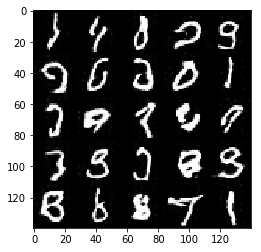

Epoch 8/10... Discriminator Loss: 1.1730... Generator Loss: 0.9309 Sum Loss: 2.1038
Epoch 8/10... Discriminator Loss: 1.0141... Generator Loss: 0.9751 Sum Loss: 1.9892
Epoch 8/10... Discriminator Loss: 1.0011... Generator Loss: 1.0853 Sum Loss: 2.0864
Epoch 8/10... Discriminator Loss: 1.0407... Generator Loss: 1.0839 Sum Loss: 2.1246
Epoch 8/10... Discriminator Loss: 1.0639... Generator Loss: 1.0784 Sum Loss: 2.1423
Epoch 8/10... Discriminator Loss: 1.0006... Generator Loss: 1.0419 Sum Loss: 2.0425
Epoch 8/10... Discriminator Loss: 1.0471... Generator Loss: 1.3009 Sum Loss: 2.3480
Epoch 8/10... Discriminator Loss: 1.0020... Generator Loss: 1.0011 Sum Loss: 2.0032
Epoch 8/10... Discriminator Loss: 1.0424... Generator Loss: 1.0627 Sum Loss: 2.1052
Epoch 8/10... Discriminator Loss: 1.1022... Generator Loss: 0.9370 Sum Loss: 2.0392


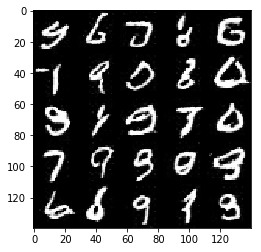

Epoch 8/10... Discriminator Loss: 1.0490... Generator Loss: 0.8599 Sum Loss: 1.9088
Epoch 8/10... Discriminator Loss: 1.1310... Generator Loss: 1.0431 Sum Loss: 2.1740
Epoch 9/10... Discriminator Loss: 1.1280... Generator Loss: 0.9204 Sum Loss: 2.0484
Epoch 9/10... Discriminator Loss: 1.0544... Generator Loss: 1.0228 Sum Loss: 2.0772
Epoch 9/10... Discriminator Loss: 1.1235... Generator Loss: 0.9464 Sum Loss: 2.0699
Epoch 9/10... Discriminator Loss: 1.0313... Generator Loss: 1.1786 Sum Loss: 2.2099
Epoch 9/10... Discriminator Loss: 1.0547... Generator Loss: 0.9427 Sum Loss: 1.9974
Epoch 9/10... Discriminator Loss: 1.2446... Generator Loss: 1.0134 Sum Loss: 2.2579
Epoch 9/10... Discriminator Loss: 1.0761... Generator Loss: 1.0228 Sum Loss: 2.0989
Epoch 9/10... Discriminator Loss: 1.0355... Generator Loss: 1.0622 Sum Loss: 2.0978


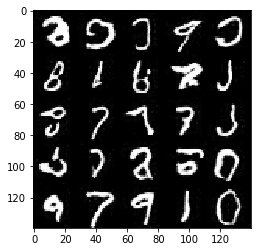

Epoch 9/10... Discriminator Loss: 1.0487... Generator Loss: 1.0181 Sum Loss: 2.0668
Epoch 9/10... Discriminator Loss: 1.1542... Generator Loss: 0.8980 Sum Loss: 2.0521
Epoch 9/10... Discriminator Loss: 1.0311... Generator Loss: 0.9469 Sum Loss: 1.9780
Epoch 9/10... Discriminator Loss: 1.1039... Generator Loss: 0.9259 Sum Loss: 2.0298
Epoch 9/10... Discriminator Loss: 1.0568... Generator Loss: 0.9778 Sum Loss: 2.0345
Epoch 9/10... Discriminator Loss: 1.0186... Generator Loss: 1.0538 Sum Loss: 2.0724
Epoch 9/10... Discriminator Loss: 1.1351... Generator Loss: 0.9202 Sum Loss: 2.0553
Epoch 9/10... Discriminator Loss: 1.0297... Generator Loss: 1.0677 Sum Loss: 2.0974
Epoch 9/10... Discriminator Loss: 1.1242... Generator Loss: 0.9138 Sum Loss: 2.0380
Epoch 9/10... Discriminator Loss: 1.0672... Generator Loss: 0.9910 Sum Loss: 2.0582


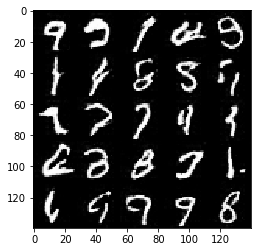

Epoch 9/10... Discriminator Loss: 1.1037... Generator Loss: 0.9126 Sum Loss: 2.0163
Epoch 9/10... Discriminator Loss: 1.0611... Generator Loss: 1.0983 Sum Loss: 2.1594
Epoch 9/10... Discriminator Loss: 1.1531... Generator Loss: 0.9697 Sum Loss: 2.1228
Epoch 9/10... Discriminator Loss: 1.0116... Generator Loss: 1.0444 Sum Loss: 2.0561
Epoch 9/10... Discriminator Loss: 1.0742... Generator Loss: 1.0260 Sum Loss: 2.1002
Epoch 9/10... Discriminator Loss: 1.0345... Generator Loss: 1.0366 Sum Loss: 2.0711
Epoch 10/10... Discriminator Loss: 1.1019... Generator Loss: 0.8618 Sum Loss: 1.9638
Epoch 10/10... Discriminator Loss: 1.0665... Generator Loss: 0.9114 Sum Loss: 1.9779
Epoch 10/10... Discriminator Loss: 1.1645... Generator Loss: 0.8083 Sum Loss: 1.9727
Epoch 10/10... Discriminator Loss: 1.0351... Generator Loss: 1.0041 Sum Loss: 2.0393


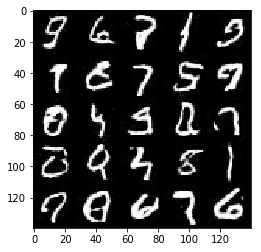

Epoch 10/10... Discriminator Loss: 1.0526... Generator Loss: 1.0496 Sum Loss: 2.1022
Epoch 10/10... Discriminator Loss: 0.9614... Generator Loss: 1.3075 Sum Loss: 2.2689
Epoch 10/10... Discriminator Loss: 1.1245... Generator Loss: 0.9739 Sum Loss: 2.0984
Epoch 10/10... Discriminator Loss: 0.9694... Generator Loss: 1.0132 Sum Loss: 1.9826
Epoch 10/10... Discriminator Loss: 1.0915... Generator Loss: 0.9030 Sum Loss: 1.9945
Epoch 10/10... Discriminator Loss: 1.0653... Generator Loss: 0.9426 Sum Loss: 2.0080
Epoch 10/10... Discriminator Loss: 0.9744... Generator Loss: 1.1761 Sum Loss: 2.1505
Epoch 10/10... Discriminator Loss: 1.4369... Generator Loss: 0.9665 Sum Loss: 2.4034
Epoch 10/10... Discriminator Loss: 1.1710... Generator Loss: 0.9225 Sum Loss: 2.0935
Epoch 10/10... Discriminator Loss: 1.0467... Generator Loss: 1.0259 Sum Loss: 2.0726


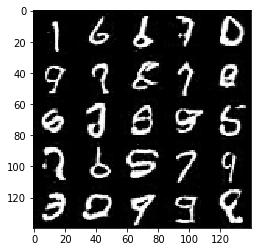

Epoch 10/10... Discriminator Loss: 1.0256... Generator Loss: 0.9433 Sum Loss: 1.9689
Epoch 10/10... Discriminator Loss: 1.0280... Generator Loss: 1.0392 Sum Loss: 2.0672
Epoch 10/10... Discriminator Loss: 1.0738... Generator Loss: 1.1616 Sum Loss: 2.2354
Epoch 10/10... Discriminator Loss: 0.9721... Generator Loss: 1.0603 Sum Loss: 2.0325
Epoch 10/10... Discriminator Loss: 1.0370... Generator Loss: 1.0564 Sum Loss: 2.0934
Epoch 10/10... Discriminator Loss: 1.0040... Generator Loss: 0.9721 Sum Loss: 1.9761
Epoch 10/10... Discriminator Loss: 1.0581... Generator Loss: 0.8804 Sum Loss: 1.9385
Epoch 10/10... Discriminator Loss: 1.0615... Generator Loss: 1.0963 Sum Loss: 2.1578
Epoch 10/10... Discriminator Loss: 1.0876... Generator Loss: 0.9745 Sum Loss: 2.0620
Epoch 10/10... Discriminator Loss: 1.0822... Generator Loss: 0.9761 Sum Loss: 2.0583


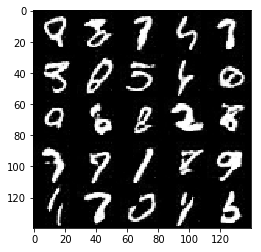

Epoch 10/10... Discriminator Loss: 0.9830... Generator Loss: 1.1219 Sum Loss: 2.1050


IndexError: list index out of range

In [36]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 1.3667... Generator Loss: 0.8178 Sum Loss: 2.1845
Epoch 1/5... Discriminator Loss: 1.3284... Generator Loss: 0.7719 Sum Loss: 2.1003
Epoch 1/5... Discriminator Loss: 1.3166... Generator Loss: 0.8302 Sum Loss: 2.1468
Epoch 1/5... Discriminator Loss: 1.3144... Generator Loss: 0.8273 Sum Loss: 2.1417
Epoch 1/5... Discriminator Loss: 1.3960... Generator Loss: 0.7738 Sum Loss: 2.1698
Epoch 1/5... Discriminator Loss: 1.3397... Generator Loss: 0.7988 Sum Loss: 2.1385
Epoch 1/5... Discriminator Loss: 1.3110... Generator Loss: 0.7878 Sum Loss: 2.0988
Epoch 1/5... Discriminator Loss: 1.3786... Generator Loss: 0.7904 Sum Loss: 2.1690
Epoch 1/5... Discriminator Loss: 1.3338... Generator Loss: 0.8261 Sum Loss: 2.1599
Epoch 1/5... Discriminator Loss: 1.3171... Generator Loss: 0.8372 Sum Loss: 2.1543


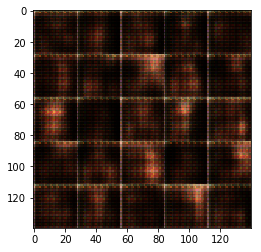

Epoch 1/5... Discriminator Loss: 1.3298... Generator Loss: 0.8223 Sum Loss: 2.1522
Epoch 1/5... Discriminator Loss: 1.4057... Generator Loss: 0.7514 Sum Loss: 2.1571
Epoch 1/5... Discriminator Loss: 1.3387... Generator Loss: 0.8296 Sum Loss: 2.1683
Epoch 1/5... Discriminator Loss: 1.3458... Generator Loss: 0.7405 Sum Loss: 2.0863
Epoch 1/5... Discriminator Loss: 1.2487... Generator Loss: 0.8540 Sum Loss: 2.1026
Epoch 1/5... Discriminator Loss: 1.3941... Generator Loss: 0.7529 Sum Loss: 2.1470
Epoch 1/5... Discriminator Loss: 1.3394... Generator Loss: 0.8092 Sum Loss: 2.1486
Epoch 1/5... Discriminator Loss: 1.3718... Generator Loss: 0.7950 Sum Loss: 2.1668
Epoch 1/5... Discriminator Loss: 1.3401... Generator Loss: 0.8246 Sum Loss: 2.1646
Epoch 1/5... Discriminator Loss: 1.3670... Generator Loss: 0.7596 Sum Loss: 2.1265


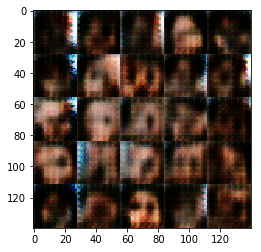

Epoch 1/5... Discriminator Loss: 1.3055... Generator Loss: 0.8248 Sum Loss: 2.1304
Epoch 1/5... Discriminator Loss: 1.3530... Generator Loss: 0.7860 Sum Loss: 2.1390
Epoch 1/5... Discriminator Loss: 1.3599... Generator Loss: 0.7935 Sum Loss: 2.1534
Epoch 1/5... Discriminator Loss: 1.3437... Generator Loss: 0.7987 Sum Loss: 2.1424
Epoch 1/5... Discriminator Loss: 1.3499... Generator Loss: 0.7994 Sum Loss: 2.1493
Epoch 1/5... Discriminator Loss: 1.3520... Generator Loss: 0.7728 Sum Loss: 2.1249
Epoch 1/5... Discriminator Loss: 1.3694... Generator Loss: 0.7812 Sum Loss: 2.1506
Epoch 1/5... Discriminator Loss: 1.3352... Generator Loss: 0.8302 Sum Loss: 2.1654
Epoch 1/5... Discriminator Loss: 1.3369... Generator Loss: 0.8211 Sum Loss: 2.1581
Epoch 1/5... Discriminator Loss: 1.3472... Generator Loss: 0.8079 Sum Loss: 2.1551


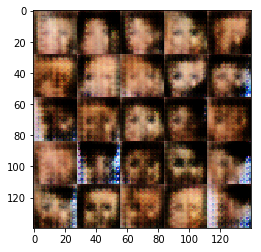

Epoch 1/5... Discriminator Loss: 1.3543... Generator Loss: 0.8235 Sum Loss: 2.1777
Epoch 1/5... Discriminator Loss: 1.3750... Generator Loss: 0.7781 Sum Loss: 2.1531
Epoch 1/5... Discriminator Loss: 1.3494... Generator Loss: 0.8035 Sum Loss: 2.1529
Epoch 1/5... Discriminator Loss: 1.3712... Generator Loss: 0.7890 Sum Loss: 2.1602
Epoch 1/5... Discriminator Loss: 1.3404... Generator Loss: 0.7834 Sum Loss: 2.1238
Epoch 1/5... Discriminator Loss: 1.4018... Generator Loss: 0.8163 Sum Loss: 2.2181
Epoch 1/5... Discriminator Loss: 1.3856... Generator Loss: 0.7984 Sum Loss: 2.1840
Epoch 1/5... Discriminator Loss: 1.3389... Generator Loss: 0.8197 Sum Loss: 2.1585
Epoch 1/5... Discriminator Loss: 1.3615... Generator Loss: 0.8099 Sum Loss: 2.1714
Epoch 1/5... Discriminator Loss: 1.3003... Generator Loss: 0.8092 Sum Loss: 2.1095


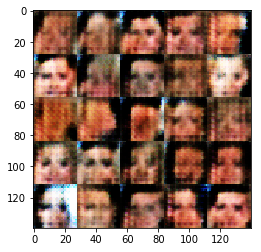

Epoch 1/5... Discriminator Loss: 1.3537... Generator Loss: 0.7845 Sum Loss: 2.1382
Epoch 1/5... Discriminator Loss: 1.3569... Generator Loss: 0.7760 Sum Loss: 2.1329
Epoch 1/5... Discriminator Loss: 1.3597... Generator Loss: 0.8210 Sum Loss: 2.1808
Epoch 1/5... Discriminator Loss: 1.3514... Generator Loss: 0.7795 Sum Loss: 2.1309
Epoch 1/5... Discriminator Loss: 1.2988... Generator Loss: 0.8737 Sum Loss: 2.1725
Epoch 1/5... Discriminator Loss: 1.3089... Generator Loss: 0.7883 Sum Loss: 2.0972
Epoch 1/5... Discriminator Loss: 1.3226... Generator Loss: 0.8154 Sum Loss: 2.1379
Epoch 1/5... Discriminator Loss: 1.3125... Generator Loss: 0.8048 Sum Loss: 2.1172
Epoch 1/5... Discriminator Loss: 1.2936... Generator Loss: 0.8607 Sum Loss: 2.1543
Epoch 1/5... Discriminator Loss: 1.3015... Generator Loss: 0.8446 Sum Loss: 2.1461


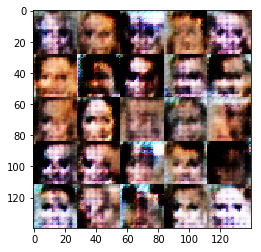

Epoch 1/5... Discriminator Loss: 1.3552... Generator Loss: 0.8244 Sum Loss: 2.1796
Epoch 1/5... Discriminator Loss: 1.3918... Generator Loss: 0.8103 Sum Loss: 2.2021
Epoch 1/5... Discriminator Loss: 1.3663... Generator Loss: 0.8252 Sum Loss: 2.1915
Epoch 1/5... Discriminator Loss: 1.2778... Generator Loss: 0.8297 Sum Loss: 2.1075
Epoch 1/5... Discriminator Loss: 1.3176... Generator Loss: 0.8129 Sum Loss: 2.1305
Epoch 1/5... Discriminator Loss: 1.2730... Generator Loss: 0.7997 Sum Loss: 2.0727
Epoch 1/5... Discriminator Loss: 1.3253... Generator Loss: 0.8028 Sum Loss: 2.1281
Epoch 1/5... Discriminator Loss: 1.4332... Generator Loss: 0.7328 Sum Loss: 2.1660
Epoch 1/5... Discriminator Loss: 1.2780... Generator Loss: 0.8582 Sum Loss: 2.1362
Epoch 1/5... Discriminator Loss: 1.3470... Generator Loss: 0.7806 Sum Loss: 2.1276


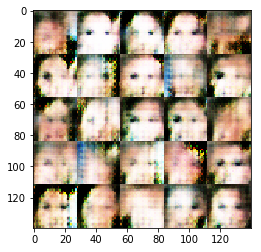

Epoch 1/5... Discriminator Loss: 1.2873... Generator Loss: 0.8008 Sum Loss: 2.0882
Epoch 1/5... Discriminator Loss: 1.2862... Generator Loss: 0.8504 Sum Loss: 2.1366
Epoch 1/5... Discriminator Loss: 1.3036... Generator Loss: 0.7802 Sum Loss: 2.0838
Epoch 1/5... Discriminator Loss: 1.3057... Generator Loss: 0.8160 Sum Loss: 2.1216
Epoch 1/5... Discriminator Loss: 1.3662... Generator Loss: 0.7688 Sum Loss: 2.1350
Epoch 1/5... Discriminator Loss: 1.2738... Generator Loss: 0.8289 Sum Loss: 2.1027
Epoch 1/5... Discriminator Loss: 1.3186... Generator Loss: 0.7849 Sum Loss: 2.1035
Epoch 1/5... Discriminator Loss: 1.2934... Generator Loss: 0.8547 Sum Loss: 2.1481
Epoch 1/5... Discriminator Loss: 1.3612... Generator Loss: 0.8227 Sum Loss: 2.1839
Epoch 1/5... Discriminator Loss: 1.3273... Generator Loss: 0.8236 Sum Loss: 2.1509


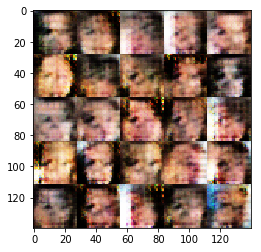

Epoch 1/5... Discriminator Loss: 1.3198... Generator Loss: 0.8289 Sum Loss: 2.1487
Epoch 1/5... Discriminator Loss: 1.3391... Generator Loss: 0.8202 Sum Loss: 2.1593
Epoch 1/5... Discriminator Loss: 1.3190... Generator Loss: 0.8594 Sum Loss: 2.1784
Epoch 1/5... Discriminator Loss: 1.3535... Generator Loss: 0.8283 Sum Loss: 2.1818
Epoch 1/5... Discriminator Loss: 1.2982... Generator Loss: 0.7739 Sum Loss: 2.0721
Epoch 1/5... Discriminator Loss: 1.3308... Generator Loss: 0.8462 Sum Loss: 2.1770
Epoch 1/5... Discriminator Loss: 1.3378... Generator Loss: 0.8206 Sum Loss: 2.1584
Epoch 1/5... Discriminator Loss: 1.3443... Generator Loss: 0.7877 Sum Loss: 2.1320
Epoch 1/5... Discriminator Loss: 1.3335... Generator Loss: 0.8119 Sum Loss: 2.1454
Epoch 1/5... Discriminator Loss: 1.2958... Generator Loss: 0.7977 Sum Loss: 2.0935


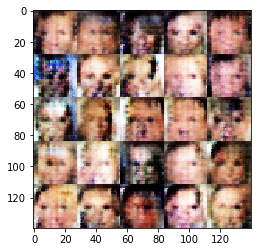

Epoch 1/5... Discriminator Loss: 1.3856... Generator Loss: 0.7738 Sum Loss: 2.1593
Epoch 1/5... Discriminator Loss: 1.3795... Generator Loss: 0.7887 Sum Loss: 2.1682
Epoch 1/5... Discriminator Loss: 1.3279... Generator Loss: 0.7973 Sum Loss: 2.1251
Epoch 1/5... Discriminator Loss: 1.3371... Generator Loss: 0.7933 Sum Loss: 2.1304
Epoch 1/5... Discriminator Loss: 1.3095... Generator Loss: 0.7990 Sum Loss: 2.1085
Epoch 1/5... Discriminator Loss: 1.3247... Generator Loss: 0.8043 Sum Loss: 2.1290
Epoch 1/5... Discriminator Loss: 1.3510... Generator Loss: 0.8001 Sum Loss: 2.1511
Epoch 1/5... Discriminator Loss: 1.3366... Generator Loss: 0.8109 Sum Loss: 2.1475
Epoch 1/5... Discriminator Loss: 1.3662... Generator Loss: 0.7867 Sum Loss: 2.1529
Epoch 1/5... Discriminator Loss: 1.3181... Generator Loss: 0.8243 Sum Loss: 2.1423


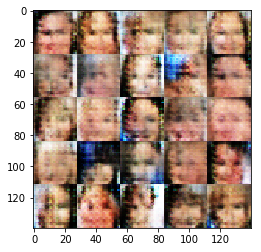

Epoch 1/5... Discriminator Loss: 1.3462... Generator Loss: 0.7552 Sum Loss: 2.1014
Epoch 1/5... Discriminator Loss: 1.3795... Generator Loss: 0.7318 Sum Loss: 2.1113
Epoch 1/5... Discriminator Loss: 1.3415... Generator Loss: 0.7556 Sum Loss: 2.0971
Epoch 1/5... Discriminator Loss: 1.2880... Generator Loss: 0.8782 Sum Loss: 2.1661
Epoch 1/5... Discriminator Loss: 1.3377... Generator Loss: 0.7768 Sum Loss: 2.1145
Epoch 1/5... Discriminator Loss: 1.3443... Generator Loss: 0.7517 Sum Loss: 2.0960
Epoch 1/5... Discriminator Loss: 1.3517... Generator Loss: 0.8077 Sum Loss: 2.1594
Epoch 1/5... Discriminator Loss: 1.3837... Generator Loss: 0.7567 Sum Loss: 2.1404
Epoch 1/5... Discriminator Loss: 1.3256... Generator Loss: 0.8092 Sum Loss: 2.1348
Epoch 1/5... Discriminator Loss: 1.1598... Generator Loss: 0.8325 Sum Loss: 1.9923


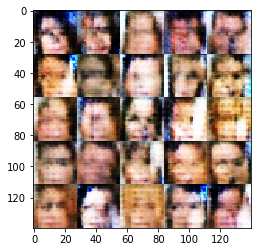

Epoch 1/5... Discriminator Loss: 1.2717... Generator Loss: 0.7750 Sum Loss: 2.0467
Epoch 1/5... Discriminator Loss: 1.3744... Generator Loss: 0.7653 Sum Loss: 2.1397
Epoch 1/5... Discriminator Loss: 1.3700... Generator Loss: 0.7701 Sum Loss: 2.1400
Epoch 1/5... Discriminator Loss: 1.3199... Generator Loss: 0.7718 Sum Loss: 2.0917
Epoch 1/5... Discriminator Loss: 1.3576... Generator Loss: 0.7621 Sum Loss: 2.1197
Epoch 1/5... Discriminator Loss: 1.3060... Generator Loss: 0.7755 Sum Loss: 2.0815
Epoch 1/5... Discriminator Loss: 1.3147... Generator Loss: 0.8220 Sum Loss: 2.1366
Epoch 1/5... Discriminator Loss: 1.3520... Generator Loss: 0.8287 Sum Loss: 2.1806
Epoch 1/5... Discriminator Loss: 1.3579... Generator Loss: 0.7380 Sum Loss: 2.0960
Epoch 1/5... Discriminator Loss: 1.3389... Generator Loss: 0.8405 Sum Loss: 2.1794


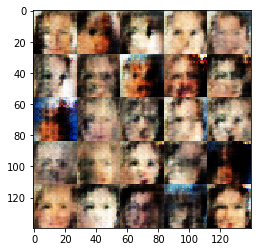

Epoch 1/5... Discriminator Loss: 1.4104... Generator Loss: 0.7844 Sum Loss: 2.1948
Epoch 1/5... Discriminator Loss: 1.3839... Generator Loss: 0.7884 Sum Loss: 2.1724
Epoch 1/5... Discriminator Loss: 1.3050... Generator Loss: 0.7956 Sum Loss: 2.1006
Epoch 1/5... Discriminator Loss: 1.3612... Generator Loss: 0.6898 Sum Loss: 2.0510
Epoch 1/5... Discriminator Loss: 1.3525... Generator Loss: 0.8108 Sum Loss: 2.1633
Epoch 1/5... Discriminator Loss: 1.3792... Generator Loss: 0.7646 Sum Loss: 2.1438
Epoch 1/5... Discriminator Loss: 1.3335... Generator Loss: 0.8354 Sum Loss: 2.1689
Epoch 1/5... Discriminator Loss: 1.3556... Generator Loss: 0.7623 Sum Loss: 2.1179
Epoch 1/5... Discriminator Loss: 1.4095... Generator Loss: 0.7650 Sum Loss: 2.1745
Epoch 1/5... Discriminator Loss: 1.3623... Generator Loss: 0.8021 Sum Loss: 2.1644


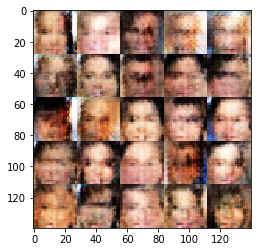

Epoch 1/5... Discriminator Loss: 1.3654... Generator Loss: 0.8122 Sum Loss: 2.1777
Epoch 1/5... Discriminator Loss: 1.3501... Generator Loss: 0.8194 Sum Loss: 2.1695
Epoch 1/5... Discriminator Loss: 1.2918... Generator Loss: 0.8528 Sum Loss: 2.1446
Epoch 1/5... Discriminator Loss: 1.3233... Generator Loss: 0.8482 Sum Loss: 2.1716
Epoch 1/5... Discriminator Loss: 1.3743... Generator Loss: 0.7700 Sum Loss: 2.1443
Epoch 1/5... Discriminator Loss: 1.3555... Generator Loss: 0.7872 Sum Loss: 2.1427
Epoch 1/5... Discriminator Loss: 1.3349... Generator Loss: 0.8282 Sum Loss: 2.1631
Epoch 1/5... Discriminator Loss: 1.3561... Generator Loss: 0.8122 Sum Loss: 2.1684
Epoch 1/5... Discriminator Loss: 1.3271... Generator Loss: 0.8413 Sum Loss: 2.1684
Epoch 1/5... Discriminator Loss: 1.3387... Generator Loss: 0.8156 Sum Loss: 2.1543


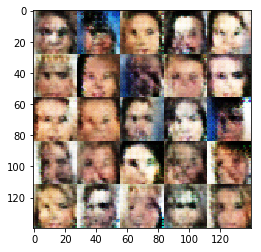

Epoch 1/5... Discriminator Loss: 1.3632... Generator Loss: 0.8236 Sum Loss: 2.1868
Epoch 1/5... Discriminator Loss: 1.3325... Generator Loss: 0.7649 Sum Loss: 2.0974
Epoch 1/5... Discriminator Loss: 1.3528... Generator Loss: 0.8605 Sum Loss: 2.2133
Epoch 1/5... Discriminator Loss: 1.3948... Generator Loss: 0.7742 Sum Loss: 2.1690
Epoch 1/5... Discriminator Loss: 1.3619... Generator Loss: 0.7980 Sum Loss: 2.1599
Epoch 1/5... Discriminator Loss: 1.3670... Generator Loss: 0.7794 Sum Loss: 2.1464
Epoch 1/5... Discriminator Loss: 1.2863... Generator Loss: 0.8360 Sum Loss: 2.1223
Epoch 1/5... Discriminator Loss: 1.3926... Generator Loss: 0.7722 Sum Loss: 2.1648
Epoch 1/5... Discriminator Loss: 1.3495... Generator Loss: 0.7949 Sum Loss: 2.1444
Epoch 1/5... Discriminator Loss: 1.3605... Generator Loss: 0.8344 Sum Loss: 2.1949


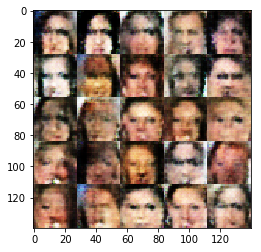

Epoch 1/5... Discriminator Loss: 1.2576... Generator Loss: 0.8770 Sum Loss: 2.1346
Epoch 1/5... Discriminator Loss: 1.3765... Generator Loss: 0.7506 Sum Loss: 2.1270
Epoch 1/5... Discriminator Loss: 1.3318... Generator Loss: 0.7696 Sum Loss: 2.1014
Epoch 1/5... Discriminator Loss: 1.3484... Generator Loss: 0.7541 Sum Loss: 2.1025
Epoch 1/5... Discriminator Loss: 1.3712... Generator Loss: 0.8194 Sum Loss: 2.1906
Epoch 1/5... Discriminator Loss: 1.3104... Generator Loss: 0.8062 Sum Loss: 2.1166
Epoch 1/5... Discriminator Loss: 1.3406... Generator Loss: 0.7946 Sum Loss: 2.1351
Epoch 1/5... Discriminator Loss: 1.3079... Generator Loss: 0.8150 Sum Loss: 2.1229
Epoch 1/5... Discriminator Loss: 1.2866... Generator Loss: 0.8174 Sum Loss: 2.1040
Epoch 1/5... Discriminator Loss: 1.3883... Generator Loss: 0.8245 Sum Loss: 2.2128


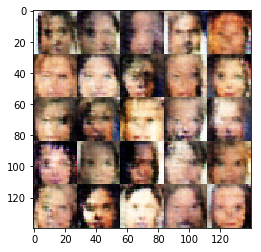

Epoch 1/5... Discriminator Loss: 1.3557... Generator Loss: 0.8163 Sum Loss: 2.1720
Epoch 2/5... Discriminator Loss: 1.4286... Generator Loss: 0.7613 Sum Loss: 2.1899
Epoch 2/5... Discriminator Loss: 1.3091... Generator Loss: 0.7955 Sum Loss: 2.1045
Epoch 2/5... Discriminator Loss: 1.3249... Generator Loss: 0.8072 Sum Loss: 2.1321
Epoch 2/5... Discriminator Loss: 1.3555... Generator Loss: 0.7723 Sum Loss: 2.1278
Epoch 2/5... Discriminator Loss: 1.3599... Generator Loss: 0.7963 Sum Loss: 2.1562
Epoch 2/5... Discriminator Loss: 1.3944... Generator Loss: 0.7763 Sum Loss: 2.1707
Epoch 2/5... Discriminator Loss: 1.3410... Generator Loss: 0.7871 Sum Loss: 2.1282
Epoch 2/5... Discriminator Loss: 1.3808... Generator Loss: 0.7754 Sum Loss: 2.1562
Epoch 2/5... Discriminator Loss: 1.3613... Generator Loss: 0.7851 Sum Loss: 2.1464


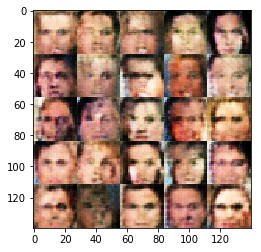

Epoch 2/5... Discriminator Loss: 1.3359... Generator Loss: 0.8293 Sum Loss: 2.1652
Epoch 2/5... Discriminator Loss: 1.3789... Generator Loss: 0.8146 Sum Loss: 2.1936
Epoch 2/5... Discriminator Loss: 1.3460... Generator Loss: 0.8001 Sum Loss: 2.1461
Epoch 2/5... Discriminator Loss: 1.3181... Generator Loss: 0.8198 Sum Loss: 2.1379
Epoch 2/5... Discriminator Loss: 1.3266... Generator Loss: 0.8367 Sum Loss: 2.1633
Epoch 2/5... Discriminator Loss: 1.3612... Generator Loss: 0.7204 Sum Loss: 2.0816
Epoch 2/5... Discriminator Loss: 1.3710... Generator Loss: 0.7775 Sum Loss: 2.1485
Epoch 2/5... Discriminator Loss: 1.3526... Generator Loss: 0.7780 Sum Loss: 2.1306
Epoch 2/5... Discriminator Loss: 1.3744... Generator Loss: 0.7817 Sum Loss: 2.1561
Epoch 2/5... Discriminator Loss: 1.3545... Generator Loss: 0.7618 Sum Loss: 2.1163


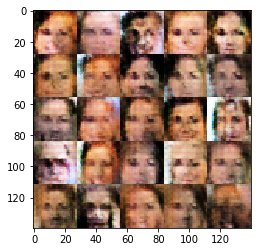

Epoch 2/5... Discriminator Loss: 1.3406... Generator Loss: 0.8085 Sum Loss: 2.1490
Epoch 2/5... Discriminator Loss: 1.4473... Generator Loss: 0.7564 Sum Loss: 2.2036
Epoch 2/5... Discriminator Loss: 1.3859... Generator Loss: 0.7933 Sum Loss: 2.1791
Epoch 2/5... Discriminator Loss: 1.3472... Generator Loss: 0.7917 Sum Loss: 2.1389
Epoch 2/5... Discriminator Loss: 1.3576... Generator Loss: 0.8289 Sum Loss: 2.1864
Epoch 2/5... Discriminator Loss: 1.2823... Generator Loss: 0.8039 Sum Loss: 2.0862
Epoch 2/5... Discriminator Loss: 1.3277... Generator Loss: 0.8263 Sum Loss: 2.1540
Epoch 2/5... Discriminator Loss: 1.3748... Generator Loss: 0.7834 Sum Loss: 2.1581
Epoch 2/5... Discriminator Loss: 1.3584... Generator Loss: 0.7676 Sum Loss: 2.1260
Epoch 2/5... Discriminator Loss: 1.3905... Generator Loss: 0.8061 Sum Loss: 2.1966


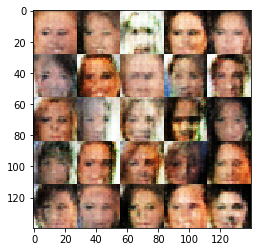

Epoch 2/5... Discriminator Loss: 1.3469... Generator Loss: 0.8332 Sum Loss: 2.1801
Epoch 2/5... Discriminator Loss: 1.4296... Generator Loss: 0.7435 Sum Loss: 2.1730
Epoch 2/5... Discriminator Loss: 1.3853... Generator Loss: 0.7512 Sum Loss: 2.1365
Epoch 2/5... Discriminator Loss: 1.3598... Generator Loss: 0.7833 Sum Loss: 2.1432
Epoch 2/5... Discriminator Loss: 1.4289... Generator Loss: 0.7092 Sum Loss: 2.1381
Epoch 2/5... Discriminator Loss: 1.3983... Generator Loss: 0.7617 Sum Loss: 2.1600
Epoch 2/5... Discriminator Loss: 1.2943... Generator Loss: 0.8455 Sum Loss: 2.1397
Epoch 2/5... Discriminator Loss: 1.3437... Generator Loss: 0.8085 Sum Loss: 2.1521
Epoch 2/5... Discriminator Loss: 1.4022... Generator Loss: 0.6582 Sum Loss: 2.0604
Epoch 2/5... Discriminator Loss: 1.2780... Generator Loss: 0.8786 Sum Loss: 2.1565


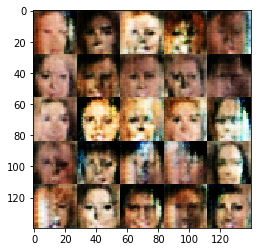

Epoch 2/5... Discriminator Loss: 1.2988... Generator Loss: 0.8562 Sum Loss: 2.1550
Epoch 2/5... Discriminator Loss: 1.2593... Generator Loss: 0.8713 Sum Loss: 2.1306
Epoch 2/5... Discriminator Loss: 1.2775... Generator Loss: 0.9027 Sum Loss: 2.1802
Epoch 2/5... Discriminator Loss: 1.3012... Generator Loss: 0.8275 Sum Loss: 2.1287
Epoch 2/5... Discriminator Loss: 1.2863... Generator Loss: 0.8154 Sum Loss: 2.1017
Epoch 2/5... Discriminator Loss: 1.2971... Generator Loss: 0.8042 Sum Loss: 2.1013
Epoch 2/5... Discriminator Loss: 1.3004... Generator Loss: 0.8222 Sum Loss: 2.1226
Epoch 2/5... Discriminator Loss: 1.3432... Generator Loss: 0.7904 Sum Loss: 2.1335
Epoch 2/5... Discriminator Loss: 1.3713... Generator Loss: 0.7598 Sum Loss: 2.1312
Epoch 2/5... Discriminator Loss: 1.4084... Generator Loss: 0.7483 Sum Loss: 2.1567


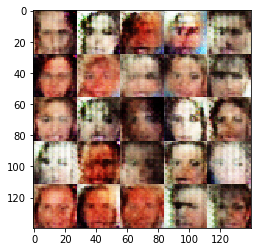

Epoch 2/5... Discriminator Loss: 1.3740... Generator Loss: 0.7971 Sum Loss: 2.1711
Epoch 2/5... Discriminator Loss: 1.3122... Generator Loss: 0.8157 Sum Loss: 2.1279
Epoch 2/5... Discriminator Loss: 1.3954... Generator Loss: 0.8116 Sum Loss: 2.2070
Epoch 2/5... Discriminator Loss: 1.2676... Generator Loss: 0.8908 Sum Loss: 2.1584
Epoch 2/5... Discriminator Loss: 1.3412... Generator Loss: 0.8080 Sum Loss: 2.1492
Epoch 2/5... Discriminator Loss: 1.3435... Generator Loss: 0.7953 Sum Loss: 2.1388
Epoch 2/5... Discriminator Loss: 1.3602... Generator Loss: 0.7934 Sum Loss: 2.1536
Epoch 2/5... Discriminator Loss: 1.4224... Generator Loss: 0.7636 Sum Loss: 2.1860
Epoch 2/5... Discriminator Loss: 1.3765... Generator Loss: 0.8249 Sum Loss: 2.2014
Epoch 2/5... Discriminator Loss: 1.3432... Generator Loss: 0.8090 Sum Loss: 2.1522


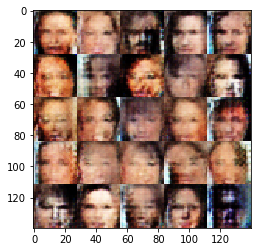

Epoch 2/5... Discriminator Loss: 1.2557... Generator Loss: 0.8738 Sum Loss: 2.1295
Epoch 2/5... Discriminator Loss: 1.3995... Generator Loss: 0.7582 Sum Loss: 2.1577
Epoch 2/5... Discriminator Loss: 1.3352... Generator Loss: 0.8103 Sum Loss: 2.1455
Epoch 2/5... Discriminator Loss: 1.3182... Generator Loss: 0.7838 Sum Loss: 2.1020
Epoch 2/5... Discriminator Loss: 1.2990... Generator Loss: 0.7998 Sum Loss: 2.0987
Epoch 2/5... Discriminator Loss: 1.3983... Generator Loss: 0.7761 Sum Loss: 2.1744
Epoch 2/5... Discriminator Loss: 1.3068... Generator Loss: 0.8006 Sum Loss: 2.1073
Epoch 2/5... Discriminator Loss: 1.3361... Generator Loss: 0.8899 Sum Loss: 2.2261
Epoch 2/5... Discriminator Loss: 1.3723... Generator Loss: 0.7431 Sum Loss: 2.1154
Epoch 2/5... Discriminator Loss: 1.4050... Generator Loss: 0.7542 Sum Loss: 2.1593


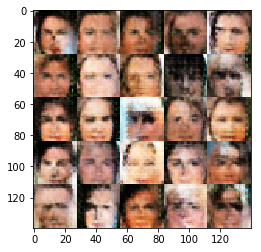

Epoch 2/5... Discriminator Loss: 1.3754... Generator Loss: 0.7554 Sum Loss: 2.1308
Epoch 2/5... Discriminator Loss: 1.2609... Generator Loss: 0.8240 Sum Loss: 2.0849
Epoch 2/5... Discriminator Loss: 1.3795... Generator Loss: 0.7520 Sum Loss: 2.1314
Epoch 2/5... Discriminator Loss: 1.3553... Generator Loss: 0.7502 Sum Loss: 2.1055
Epoch 2/5... Discriminator Loss: 1.3771... Generator Loss: 0.7717 Sum Loss: 2.1488
Epoch 2/5... Discriminator Loss: 1.5028... Generator Loss: 0.7361 Sum Loss: 2.2389
Epoch 2/5... Discriminator Loss: 1.2942... Generator Loss: 0.8058 Sum Loss: 2.1000
Epoch 2/5... Discriminator Loss: 1.3705... Generator Loss: 0.7763 Sum Loss: 2.1468
Epoch 2/5... Discriminator Loss: 1.3146... Generator Loss: 0.8444 Sum Loss: 2.1590
Epoch 2/5... Discriminator Loss: 1.4139... Generator Loss: 0.7521 Sum Loss: 2.1660


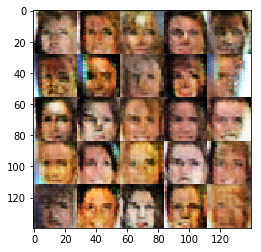

Epoch 2/5... Discriminator Loss: 1.3931... Generator Loss: 0.7473 Sum Loss: 2.1405
Epoch 2/5... Discriminator Loss: 1.3792... Generator Loss: 0.7799 Sum Loss: 2.1590
Epoch 2/5... Discriminator Loss: 1.3141... Generator Loss: 0.8195 Sum Loss: 2.1336
Epoch 2/5... Discriminator Loss: 1.3391... Generator Loss: 0.8161 Sum Loss: 2.1552
Epoch 2/5... Discriminator Loss: 1.3913... Generator Loss: 0.7981 Sum Loss: 2.1894
Epoch 2/5... Discriminator Loss: 1.4199... Generator Loss: 0.7849 Sum Loss: 2.2048
Epoch 2/5... Discriminator Loss: 1.4505... Generator Loss: 0.7790 Sum Loss: 2.2294
Epoch 2/5... Discriminator Loss: 1.3624... Generator Loss: 0.7763 Sum Loss: 2.1388
Epoch 2/5... Discriminator Loss: 1.3037... Generator Loss: 0.7766 Sum Loss: 2.0803
Epoch 2/5... Discriminator Loss: 1.3870... Generator Loss: 0.7639 Sum Loss: 2.1509


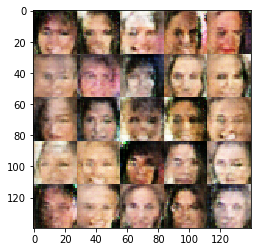

Epoch 2/5... Discriminator Loss: 1.3797... Generator Loss: 0.7910 Sum Loss: 2.1707
Epoch 2/5... Discriminator Loss: 1.3363... Generator Loss: 0.8189 Sum Loss: 2.1552
Epoch 2/5... Discriminator Loss: 1.3235... Generator Loss: 0.8395 Sum Loss: 2.1630
Epoch 2/5... Discriminator Loss: 1.3521... Generator Loss: 0.7612 Sum Loss: 2.1133
Epoch 2/5... Discriminator Loss: 1.3183... Generator Loss: 0.8306 Sum Loss: 2.1490
Epoch 2/5... Discriminator Loss: 1.5095... Generator Loss: 0.6515 Sum Loss: 2.1610
Epoch 2/5... Discriminator Loss: 1.3930... Generator Loss: 0.7794 Sum Loss: 2.1724
Epoch 2/5... Discriminator Loss: 1.4301... Generator Loss: 0.8296 Sum Loss: 2.2597
Epoch 2/5... Discriminator Loss: 1.4307... Generator Loss: 0.6998 Sum Loss: 2.1305
Epoch 2/5... Discriminator Loss: 1.3396... Generator Loss: 0.8054 Sum Loss: 2.1450


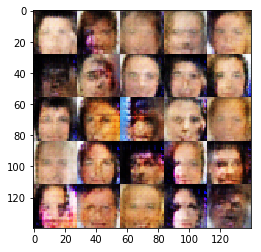

Epoch 2/5... Discriminator Loss: 1.3644... Generator Loss: 0.8240 Sum Loss: 2.1885
Epoch 2/5... Discriminator Loss: 1.3529... Generator Loss: 0.8026 Sum Loss: 2.1555
Epoch 2/5... Discriminator Loss: 1.3196... Generator Loss: 0.7934 Sum Loss: 2.1130
Epoch 2/5... Discriminator Loss: 1.3508... Generator Loss: 0.8007 Sum Loss: 2.1515
Epoch 2/5... Discriminator Loss: 1.2839... Generator Loss: 0.8612 Sum Loss: 2.1451
Epoch 2/5... Discriminator Loss: 1.3883... Generator Loss: 0.8005 Sum Loss: 2.1887
Epoch 2/5... Discriminator Loss: 1.3989... Generator Loss: 0.7751 Sum Loss: 2.1740
Epoch 2/5... Discriminator Loss: 1.3382... Generator Loss: 0.8059 Sum Loss: 2.1441
Epoch 2/5... Discriminator Loss: 1.3519... Generator Loss: 0.7985 Sum Loss: 2.1503
Epoch 2/5... Discriminator Loss: 1.4148... Generator Loss: 0.7626 Sum Loss: 2.1774


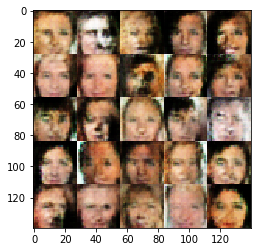

Epoch 2/5... Discriminator Loss: 1.3280... Generator Loss: 0.7822 Sum Loss: 2.1102
Epoch 2/5... Discriminator Loss: 1.3803... Generator Loss: 0.7703 Sum Loss: 2.1505
Epoch 2/5... Discriminator Loss: 1.3762... Generator Loss: 0.7926 Sum Loss: 2.1688
Epoch 2/5... Discriminator Loss: 1.3723... Generator Loss: 0.7867 Sum Loss: 2.1590
Epoch 2/5... Discriminator Loss: 1.3338... Generator Loss: 0.8381 Sum Loss: 2.1719
Epoch 2/5... Discriminator Loss: 1.3565... Generator Loss: 0.8072 Sum Loss: 2.1636
Epoch 2/5... Discriminator Loss: 1.3351... Generator Loss: 0.8047 Sum Loss: 2.1398
Epoch 2/5... Discriminator Loss: 1.2558... Generator Loss: 0.8207 Sum Loss: 2.0765
Epoch 2/5... Discriminator Loss: 1.3608... Generator Loss: 0.7884 Sum Loss: 2.1492
Epoch 2/5... Discriminator Loss: 1.3485... Generator Loss: 0.8105 Sum Loss: 2.1589


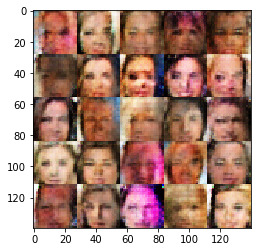

Epoch 2/5... Discriminator Loss: 1.3041... Generator Loss: 0.8029 Sum Loss: 2.1070
Epoch 2/5... Discriminator Loss: 1.3545... Generator Loss: 0.8021 Sum Loss: 2.1566
Epoch 2/5... Discriminator Loss: 1.3576... Generator Loss: 0.8053 Sum Loss: 2.1629
Epoch 2/5... Discriminator Loss: 1.2716... Generator Loss: 0.7905 Sum Loss: 2.0621
Epoch 2/5... Discriminator Loss: 1.3057... Generator Loss: 0.7979 Sum Loss: 2.1035
Epoch 2/5... Discriminator Loss: 1.3540... Generator Loss: 0.7935 Sum Loss: 2.1475
Epoch 2/5... Discriminator Loss: 1.3857... Generator Loss: 0.7557 Sum Loss: 2.1413
Epoch 2/5... Discriminator Loss: 1.3558... Generator Loss: 0.7760 Sum Loss: 2.1318
Epoch 2/5... Discriminator Loss: 1.4194... Generator Loss: 0.7296 Sum Loss: 2.1490
Epoch 2/5... Discriminator Loss: 1.3705... Generator Loss: 0.7952 Sum Loss: 2.1657


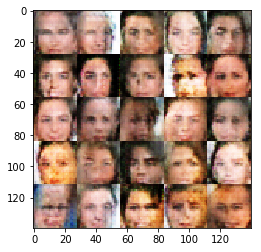

Epoch 2/5... Discriminator Loss: 1.3871... Generator Loss: 0.7360 Sum Loss: 2.1231
Epoch 2/5... Discriminator Loss: 1.3403... Generator Loss: 0.8065 Sum Loss: 2.1468
Epoch 2/5... Discriminator Loss: 1.4105... Generator Loss: 0.7560 Sum Loss: 2.1665
Epoch 2/5... Discriminator Loss: 1.3802... Generator Loss: 0.7694 Sum Loss: 2.1497
Epoch 2/5... Discriminator Loss: 1.3245... Generator Loss: 0.8005 Sum Loss: 2.1251
Epoch 2/5... Discriminator Loss: 1.3950... Generator Loss: 0.7843 Sum Loss: 2.1793
Epoch 2/5... Discriminator Loss: 1.2586... Generator Loss: 0.8413 Sum Loss: 2.0999
Epoch 2/5... Discriminator Loss: 1.3460... Generator Loss: 0.7959 Sum Loss: 2.1420
Epoch 2/5... Discriminator Loss: 1.3132... Generator Loss: 0.7742 Sum Loss: 2.0875
Epoch 2/5... Discriminator Loss: 1.3437... Generator Loss: 0.8289 Sum Loss: 2.1726


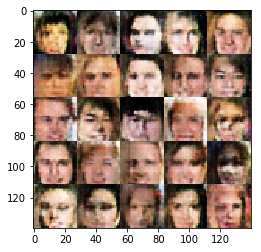

Epoch 2/5... Discriminator Loss: 1.3647... Generator Loss: 0.7567 Sum Loss: 2.1214
Epoch 2/5... Discriminator Loss: 1.3444... Generator Loss: 0.8031 Sum Loss: 2.1475
Epoch 2/5... Discriminator Loss: 1.3984... Generator Loss: 0.7487 Sum Loss: 2.1472
Epoch 2/5... Discriminator Loss: 1.4418... Generator Loss: 0.7086 Sum Loss: 2.1504
Epoch 2/5... Discriminator Loss: 1.3601... Generator Loss: 0.7731 Sum Loss: 2.1332
Epoch 2/5... Discriminator Loss: 1.3579... Generator Loss: 0.8109 Sum Loss: 2.1688
Epoch 2/5... Discriminator Loss: 1.3578... Generator Loss: 0.7837 Sum Loss: 2.1415
Epoch 2/5... Discriminator Loss: 1.2834... Generator Loss: 0.8290 Sum Loss: 2.1124
Epoch 2/5... Discriminator Loss: 1.4122... Generator Loss: 0.7837 Sum Loss: 2.1958
Epoch 2/5... Discriminator Loss: 1.4028... Generator Loss: 0.7618 Sum Loss: 2.1646


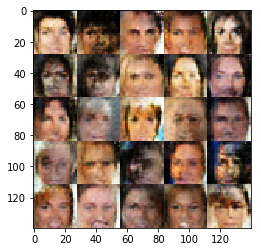

Epoch 2/5... Discriminator Loss: 1.3423... Generator Loss: 0.8148 Sum Loss: 2.1571
Epoch 2/5... Discriminator Loss: 1.3394... Generator Loss: 0.8125 Sum Loss: 2.1519
Epoch 2/5... Discriminator Loss: 1.4118... Generator Loss: 0.8050 Sum Loss: 2.2168
Epoch 3/5... Discriminator Loss: 1.2504... Generator Loss: 0.8654 Sum Loss: 2.1158
Epoch 3/5... Discriminator Loss: 1.3783... Generator Loss: 0.7472 Sum Loss: 2.1255
Epoch 3/5... Discriminator Loss: 1.3244... Generator Loss: 0.7837 Sum Loss: 2.1081
Epoch 3/5... Discriminator Loss: 1.3266... Generator Loss: 0.8513 Sum Loss: 2.1779
Epoch 3/5... Discriminator Loss: 1.3608... Generator Loss: 0.8068 Sum Loss: 2.1676
Epoch 3/5... Discriminator Loss: 1.3742... Generator Loss: 0.7771 Sum Loss: 2.1514
Epoch 3/5... Discriminator Loss: 1.3976... Generator Loss: 0.7873 Sum Loss: 2.1849


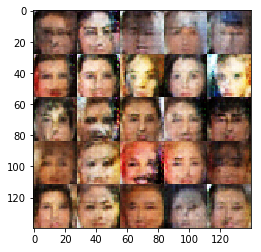

Epoch 3/5... Discriminator Loss: 1.3578... Generator Loss: 0.8182 Sum Loss: 2.1760
Epoch 3/5... Discriminator Loss: 1.3552... Generator Loss: 0.8184 Sum Loss: 2.1736
Epoch 3/5... Discriminator Loss: 1.4254... Generator Loss: 0.7573 Sum Loss: 2.1827
Epoch 3/5... Discriminator Loss: 1.3481... Generator Loss: 0.8201 Sum Loss: 2.1681
Epoch 3/5... Discriminator Loss: 1.3579... Generator Loss: 0.7960 Sum Loss: 2.1539
Epoch 3/5... Discriminator Loss: 1.3790... Generator Loss: 0.7667 Sum Loss: 2.1458
Epoch 3/5... Discriminator Loss: 1.4166... Generator Loss: 0.7639 Sum Loss: 2.1805
Epoch 3/5... Discriminator Loss: 1.3051... Generator Loss: 0.8282 Sum Loss: 2.1334
Epoch 3/5... Discriminator Loss: 1.3323... Generator Loss: 0.8361 Sum Loss: 2.1684
Epoch 3/5... Discriminator Loss: 1.3924... Generator Loss: 0.7913 Sum Loss: 2.1836


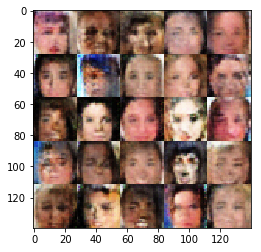

Epoch 3/5... Discriminator Loss: 1.3593... Generator Loss: 0.7941 Sum Loss: 2.1534
Epoch 3/5... Discriminator Loss: 1.3700... Generator Loss: 0.7866 Sum Loss: 2.1566
Epoch 3/5... Discriminator Loss: 1.5219... Generator Loss: 0.6384 Sum Loss: 2.1603
Epoch 3/5... Discriminator Loss: 1.3595... Generator Loss: 0.7942 Sum Loss: 2.1537
Epoch 3/5... Discriminator Loss: 1.3579... Generator Loss: 0.7704 Sum Loss: 2.1283
Epoch 3/5... Discriminator Loss: 1.4168... Generator Loss: 0.7866 Sum Loss: 2.2033
Epoch 3/5... Discriminator Loss: 1.3641... Generator Loss: 0.8042 Sum Loss: 2.1683
Epoch 3/5... Discriminator Loss: 1.3541... Generator Loss: 0.8078 Sum Loss: 2.1619
Epoch 3/5... Discriminator Loss: 1.3532... Generator Loss: 0.7949 Sum Loss: 2.1481
Epoch 3/5... Discriminator Loss: 1.3120... Generator Loss: 0.7673 Sum Loss: 2.0793


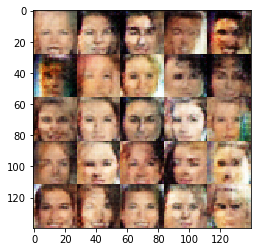

Epoch 3/5... Discriminator Loss: 1.3953... Generator Loss: 0.7465 Sum Loss: 2.1417
Epoch 3/5... Discriminator Loss: 1.3110... Generator Loss: 0.8217 Sum Loss: 2.1327
Epoch 3/5... Discriminator Loss: 1.2965... Generator Loss: 0.8268 Sum Loss: 2.1233
Epoch 3/5... Discriminator Loss: 1.4640... Generator Loss: 0.6978 Sum Loss: 2.1618
Epoch 3/5... Discriminator Loss: 1.3443... Generator Loss: 0.8281 Sum Loss: 2.1724
Epoch 3/5... Discriminator Loss: 1.4006... Generator Loss: 0.7783 Sum Loss: 2.1789
Epoch 3/5... Discriminator Loss: 1.4060... Generator Loss: 0.7522 Sum Loss: 2.1582
Epoch 3/5... Discriminator Loss: 1.3327... Generator Loss: 0.7899 Sum Loss: 2.1227
Epoch 3/5... Discriminator Loss: 1.3713... Generator Loss: 0.7696 Sum Loss: 2.1410
Epoch 3/5... Discriminator Loss: 1.3992... Generator Loss: 0.7902 Sum Loss: 2.1894


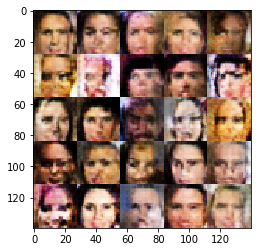

Epoch 3/5... Discriminator Loss: 1.3736... Generator Loss: 0.7687 Sum Loss: 2.1423
Epoch 3/5... Discriminator Loss: 1.3413... Generator Loss: 0.8141 Sum Loss: 2.1555
Epoch 3/5... Discriminator Loss: 1.4255... Generator Loss: 0.7593 Sum Loss: 2.1849
Epoch 3/5... Discriminator Loss: 1.3701... Generator Loss: 0.7854 Sum Loss: 2.1556
Epoch 3/5... Discriminator Loss: 1.3787... Generator Loss: 0.7759 Sum Loss: 2.1546
Epoch 3/5... Discriminator Loss: 1.5024... Generator Loss: 0.7072 Sum Loss: 2.2096
Epoch 3/5... Discriminator Loss: 1.3484... Generator Loss: 0.8288 Sum Loss: 2.1772
Epoch 3/5... Discriminator Loss: 1.4521... Generator Loss: 0.7510 Sum Loss: 2.2031
Epoch 3/5... Discriminator Loss: 1.3187... Generator Loss: 0.8720 Sum Loss: 2.1906
Epoch 3/5... Discriminator Loss: 1.3867... Generator Loss: 0.7421 Sum Loss: 2.1288


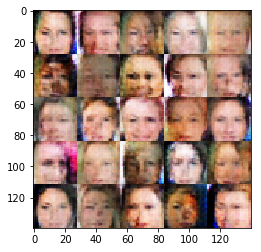

Epoch 3/5... Discriminator Loss: 1.3757... Generator Loss: 0.8071 Sum Loss: 2.1827
Epoch 3/5... Discriminator Loss: 1.3596... Generator Loss: 0.7915 Sum Loss: 2.1511
Epoch 3/5... Discriminator Loss: 1.2740... Generator Loss: 0.8548 Sum Loss: 2.1287
Epoch 3/5... Discriminator Loss: 1.4103... Generator Loss: 0.7720 Sum Loss: 2.1823
Epoch 3/5... Discriminator Loss: 1.3263... Generator Loss: 0.7875 Sum Loss: 2.1138
Epoch 3/5... Discriminator Loss: 1.3175... Generator Loss: 0.7930 Sum Loss: 2.1105
Epoch 3/5... Discriminator Loss: 1.4137... Generator Loss: 0.7547 Sum Loss: 2.1685
Epoch 3/5... Discriminator Loss: 1.2983... Generator Loss: 0.8265 Sum Loss: 2.1249
Epoch 3/5... Discriminator Loss: 1.4000... Generator Loss: 0.7830 Sum Loss: 2.1830
Epoch 3/5... Discriminator Loss: 1.3902... Generator Loss: 0.7668 Sum Loss: 2.1570


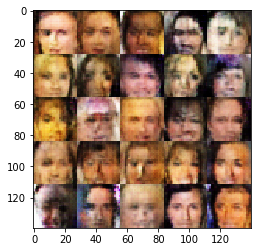

Epoch 3/5... Discriminator Loss: 1.3997... Generator Loss: 0.7664 Sum Loss: 2.1661
Epoch 3/5... Discriminator Loss: 1.2683... Generator Loss: 0.8336 Sum Loss: 2.1019
Epoch 3/5... Discriminator Loss: 1.3453... Generator Loss: 0.8161 Sum Loss: 2.1614
Epoch 3/5... Discriminator Loss: 1.3415... Generator Loss: 0.8065 Sum Loss: 2.1480
Epoch 3/5... Discriminator Loss: 1.3447... Generator Loss: 0.8093 Sum Loss: 2.1540
Epoch 3/5... Discriminator Loss: 1.3557... Generator Loss: 0.7984 Sum Loss: 2.1542
Epoch 3/5... Discriminator Loss: 1.3832... Generator Loss: 0.7927 Sum Loss: 2.1758
Epoch 3/5... Discriminator Loss: 1.4427... Generator Loss: 0.7509 Sum Loss: 2.1936
Epoch 3/5... Discriminator Loss: 1.3804... Generator Loss: 0.8095 Sum Loss: 2.1899
Epoch 3/5... Discriminator Loss: 1.3824... Generator Loss: 0.8040 Sum Loss: 2.1864


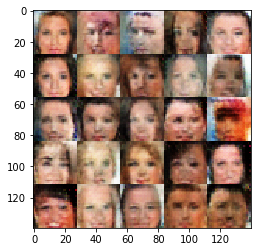

Epoch 3/5... Discriminator Loss: 1.3326... Generator Loss: 0.7759 Sum Loss: 2.1085
Epoch 3/5... Discriminator Loss: 1.3631... Generator Loss: 0.7950 Sum Loss: 2.1581
Epoch 3/5... Discriminator Loss: 1.3882... Generator Loss: 0.7791 Sum Loss: 2.1673
Epoch 3/5... Discriminator Loss: 1.3259... Generator Loss: 0.7906 Sum Loss: 2.1165
Epoch 3/5... Discriminator Loss: 1.3540... Generator Loss: 0.7890 Sum Loss: 2.1430
Epoch 3/5... Discriminator Loss: 1.3714... Generator Loss: 0.7947 Sum Loss: 2.1661
Epoch 3/5... Discriminator Loss: 1.4151... Generator Loss: 0.7485 Sum Loss: 2.1636
Epoch 3/5... Discriminator Loss: 1.3701... Generator Loss: 0.7726 Sum Loss: 2.1428
Epoch 3/5... Discriminator Loss: 1.3746... Generator Loss: 0.7775 Sum Loss: 2.1521
Epoch 3/5... Discriminator Loss: 1.4137... Generator Loss: 0.7329 Sum Loss: 2.1466


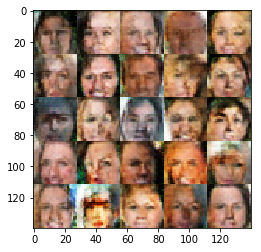

Epoch 3/5... Discriminator Loss: 1.3994... Generator Loss: 0.7514 Sum Loss: 2.1508
Epoch 3/5... Discriminator Loss: 1.4231... Generator Loss: 0.7538 Sum Loss: 2.1769
Epoch 3/5... Discriminator Loss: 1.3335... Generator Loss: 0.8197 Sum Loss: 2.1532
Epoch 3/5... Discriminator Loss: 1.3735... Generator Loss: 0.8033 Sum Loss: 2.1768
Epoch 3/5... Discriminator Loss: 1.3678... Generator Loss: 0.8077 Sum Loss: 2.1756
Epoch 3/5... Discriminator Loss: 1.3865... Generator Loss: 0.8053 Sum Loss: 2.1919
Epoch 3/5... Discriminator Loss: 1.3477... Generator Loss: 0.8196 Sum Loss: 2.1673
Epoch 3/5... Discriminator Loss: 1.4111... Generator Loss: 0.8083 Sum Loss: 2.2194
Epoch 3/5... Discriminator Loss: 1.3505... Generator Loss: 0.7620 Sum Loss: 2.1125
Epoch 3/5... Discriminator Loss: 1.4267... Generator Loss: 0.7604 Sum Loss: 2.1871


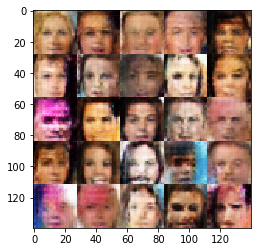

Epoch 3/5... Discriminator Loss: 1.3539... Generator Loss: 0.7700 Sum Loss: 2.1238
Epoch 3/5... Discriminator Loss: 1.3862... Generator Loss: 0.7670 Sum Loss: 2.1533
Epoch 3/5... Discriminator Loss: 1.3787... Generator Loss: 0.7847 Sum Loss: 2.1634
Epoch 3/5... Discriminator Loss: 1.3672... Generator Loss: 0.8088 Sum Loss: 2.1760
Epoch 3/5... Discriminator Loss: 1.4139... Generator Loss: 0.7395 Sum Loss: 2.1534
Epoch 3/5... Discriminator Loss: 1.3965... Generator Loss: 0.7324 Sum Loss: 2.1289
Epoch 3/5... Discriminator Loss: 1.3996... Generator Loss: 0.7777 Sum Loss: 2.1773
Epoch 3/5... Discriminator Loss: 1.3883... Generator Loss: 0.7539 Sum Loss: 2.1422
Epoch 3/5... Discriminator Loss: 1.3189... Generator Loss: 0.7920 Sum Loss: 2.1109
Epoch 3/5... Discriminator Loss: 1.3917... Generator Loss: 0.7637 Sum Loss: 2.1553


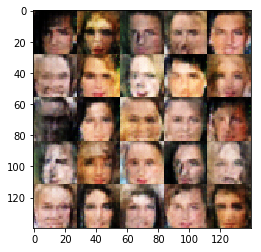

Epoch 3/5... Discriminator Loss: 1.3597... Generator Loss: 0.7932 Sum Loss: 2.1529
Epoch 3/5... Discriminator Loss: 1.3398... Generator Loss: 0.8079 Sum Loss: 2.1477
Epoch 3/5... Discriminator Loss: 1.4436... Generator Loss: 0.7173 Sum Loss: 2.1609
Epoch 3/5... Discriminator Loss: 1.3864... Generator Loss: 0.8334 Sum Loss: 2.2199
Epoch 3/5... Discriminator Loss: 1.3077... Generator Loss: 0.8033 Sum Loss: 2.1110
Epoch 3/5... Discriminator Loss: 1.4709... Generator Loss: 0.6914 Sum Loss: 2.1623
Epoch 3/5... Discriminator Loss: 1.3680... Generator Loss: 0.7858 Sum Loss: 2.1538
Epoch 3/5... Discriminator Loss: 1.3532... Generator Loss: 0.7773 Sum Loss: 2.1305
Epoch 3/5... Discriminator Loss: 1.3460... Generator Loss: 0.7981 Sum Loss: 2.1441
Epoch 3/5... Discriminator Loss: 1.3734... Generator Loss: 0.7675 Sum Loss: 2.1409


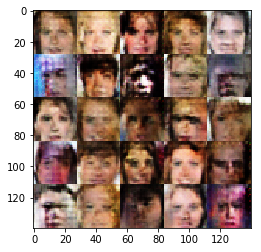

Epoch 3/5... Discriminator Loss: 1.3975... Generator Loss: 0.7614 Sum Loss: 2.1590
Epoch 3/5... Discriminator Loss: 1.3528... Generator Loss: 0.8210 Sum Loss: 2.1738
Epoch 3/5... Discriminator Loss: 1.4015... Generator Loss: 0.7415 Sum Loss: 2.1429
Epoch 3/5... Discriminator Loss: 1.3487... Generator Loss: 0.8251 Sum Loss: 2.1738
Epoch 3/5... Discriminator Loss: 1.3592... Generator Loss: 0.7853 Sum Loss: 2.1445
Epoch 3/5... Discriminator Loss: 1.3060... Generator Loss: 0.8250 Sum Loss: 2.1310
Epoch 3/5... Discriminator Loss: 1.3125... Generator Loss: 0.7833 Sum Loss: 2.0957
Epoch 3/5... Discriminator Loss: 1.3361... Generator Loss: 0.8123 Sum Loss: 2.1483
Epoch 3/5... Discriminator Loss: 1.4151... Generator Loss: 0.7968 Sum Loss: 2.2119
Epoch 3/5... Discriminator Loss: 1.4292... Generator Loss: 0.7220 Sum Loss: 2.1512


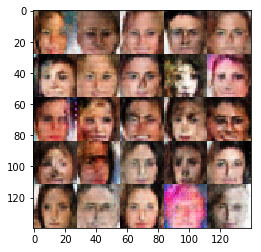

Epoch 3/5... Discriminator Loss: 1.3973... Generator Loss: 0.7797 Sum Loss: 2.1771
Epoch 3/5... Discriminator Loss: 1.2956... Generator Loss: 0.8380 Sum Loss: 2.1336
Epoch 3/5... Discriminator Loss: 1.5643... Generator Loss: 0.6174 Sum Loss: 2.1817
Epoch 3/5... Discriminator Loss: 1.3945... Generator Loss: 0.7980 Sum Loss: 2.1926
Epoch 3/5... Discriminator Loss: 1.3579... Generator Loss: 0.7575 Sum Loss: 2.1154
Epoch 3/5... Discriminator Loss: 1.3246... Generator Loss: 0.8355 Sum Loss: 2.1600
Epoch 3/5... Discriminator Loss: 1.4151... Generator Loss: 0.7471 Sum Loss: 2.1622
Epoch 3/5... Discriminator Loss: 1.3239... Generator Loss: 0.8218 Sum Loss: 2.1457
Epoch 3/5... Discriminator Loss: 1.3627... Generator Loss: 0.7751 Sum Loss: 2.1378
Epoch 3/5... Discriminator Loss: 1.2462... Generator Loss: 0.8083 Sum Loss: 2.0546


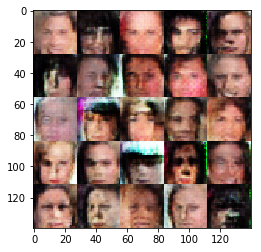

Epoch 3/5... Discriminator Loss: 1.3623... Generator Loss: 0.7809 Sum Loss: 2.1433
Epoch 3/5... Discriminator Loss: 1.4122... Generator Loss: 0.7782 Sum Loss: 2.1904
Epoch 3/5... Discriminator Loss: 1.4100... Generator Loss: 0.7706 Sum Loss: 2.1806
Epoch 3/5... Discriminator Loss: 1.3596... Generator Loss: 0.8000 Sum Loss: 2.1596
Epoch 3/5... Discriminator Loss: 1.3664... Generator Loss: 0.8017 Sum Loss: 2.1681
Epoch 3/5... Discriminator Loss: 1.3546... Generator Loss: 0.7703 Sum Loss: 2.1249
Epoch 3/5... Discriminator Loss: 1.4225... Generator Loss: 0.7279 Sum Loss: 2.1504
Epoch 3/5... Discriminator Loss: 1.3788... Generator Loss: 0.7975 Sum Loss: 2.1763
Epoch 3/5... Discriminator Loss: 1.3217... Generator Loss: 0.7621 Sum Loss: 2.0837
Epoch 3/5... Discriminator Loss: 1.4214... Generator Loss: 0.7722 Sum Loss: 2.1936


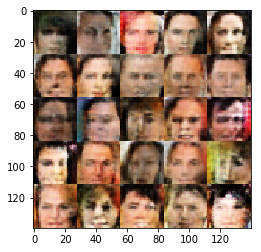

Epoch 3/5... Discriminator Loss: 1.3423... Generator Loss: 0.8213 Sum Loss: 2.1636
Epoch 3/5... Discriminator Loss: 1.3741... Generator Loss: 0.7647 Sum Loss: 2.1388
Epoch 3/5... Discriminator Loss: 1.2909... Generator Loss: 0.7911 Sum Loss: 2.0820
Epoch 3/5... Discriminator Loss: 1.3501... Generator Loss: 0.7963 Sum Loss: 2.1464
Epoch 3/5... Discriminator Loss: 1.3533... Generator Loss: 0.7971 Sum Loss: 2.1504
Epoch 3/5... Discriminator Loss: 1.3847... Generator Loss: 0.7497 Sum Loss: 2.1344
Epoch 3/5... Discriminator Loss: 1.3624... Generator Loss: 0.8195 Sum Loss: 2.1820
Epoch 3/5... Discriminator Loss: 1.4270... Generator Loss: 0.7434 Sum Loss: 2.1704
Epoch 3/5... Discriminator Loss: 1.3528... Generator Loss: 0.8147 Sum Loss: 2.1675
Epoch 3/5... Discriminator Loss: 1.4077... Generator Loss: 0.7664 Sum Loss: 2.1741


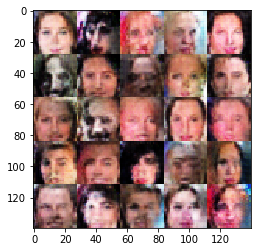

Epoch 3/5... Discriminator Loss: 1.3487... Generator Loss: 0.8241 Sum Loss: 2.1729
Epoch 3/5... Discriminator Loss: 1.4066... Generator Loss: 0.7834 Sum Loss: 2.1900
Epoch 3/5... Discriminator Loss: 1.3567... Generator Loss: 0.7801 Sum Loss: 2.1368
Epoch 3/5... Discriminator Loss: 1.3979... Generator Loss: 0.7469 Sum Loss: 2.1447
Epoch 3/5... Discriminator Loss: 1.3269... Generator Loss: 0.8028 Sum Loss: 2.1296
Epoch 4/5... Discriminator Loss: 1.4061... Generator Loss: 0.7387 Sum Loss: 2.1448
Epoch 4/5... Discriminator Loss: 1.3164... Generator Loss: 0.8049 Sum Loss: 2.1213
Epoch 4/5... Discriminator Loss: 1.3805... Generator Loss: 0.7730 Sum Loss: 2.1535
Epoch 4/5... Discriminator Loss: 1.3752... Generator Loss: 0.7828 Sum Loss: 2.1580
Epoch 4/5... Discriminator Loss: 1.3496... Generator Loss: 0.8039 Sum Loss: 2.1535


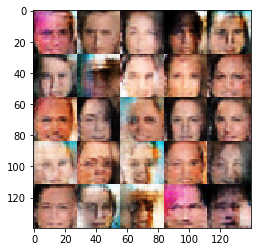

Epoch 4/5... Discriminator Loss: 1.3603... Generator Loss: 0.7805 Sum Loss: 2.1408
Epoch 4/5... Discriminator Loss: 1.3786... Generator Loss: 0.7517 Sum Loss: 2.1303
Epoch 4/5... Discriminator Loss: 1.3601... Generator Loss: 0.7867 Sum Loss: 2.1468
Epoch 4/5... Discriminator Loss: 1.3729... Generator Loss: 0.7842 Sum Loss: 2.1571
Epoch 4/5... Discriminator Loss: 1.3468... Generator Loss: 0.7876 Sum Loss: 2.1344
Epoch 4/5... Discriminator Loss: 1.2648... Generator Loss: 0.8397 Sum Loss: 2.1045
Epoch 4/5... Discriminator Loss: 1.4904... Generator Loss: 0.7027 Sum Loss: 2.1930
Epoch 4/5... Discriminator Loss: 1.3752... Generator Loss: 0.7746 Sum Loss: 2.1498
Epoch 4/5... Discriminator Loss: 1.3725... Generator Loss: 0.7779 Sum Loss: 2.1504
Epoch 4/5... Discriminator Loss: 1.4101... Generator Loss: 0.8154 Sum Loss: 2.2256


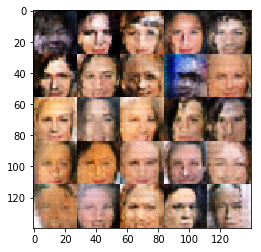

Epoch 4/5... Discriminator Loss: 1.3664... Generator Loss: 0.7881 Sum Loss: 2.1545
Epoch 4/5... Discriminator Loss: 1.3996... Generator Loss: 0.7724 Sum Loss: 2.1720
Epoch 4/5... Discriminator Loss: 1.3074... Generator Loss: 0.8528 Sum Loss: 2.1601
Epoch 4/5... Discriminator Loss: 1.3719... Generator Loss: 0.7868 Sum Loss: 2.1588
Epoch 4/5... Discriminator Loss: 1.4146... Generator Loss: 0.7189 Sum Loss: 2.1335
Epoch 4/5... Discriminator Loss: 1.3220... Generator Loss: 0.7662 Sum Loss: 2.0883
Epoch 4/5... Discriminator Loss: 1.3585... Generator Loss: 0.8133 Sum Loss: 2.1719
Epoch 4/5... Discriminator Loss: 1.3267... Generator Loss: 0.8438 Sum Loss: 2.1705
Epoch 4/5... Discriminator Loss: 1.3796... Generator Loss: 0.7629 Sum Loss: 2.1425
Epoch 4/5... Discriminator Loss: 1.3493... Generator Loss: 0.7845 Sum Loss: 2.1338


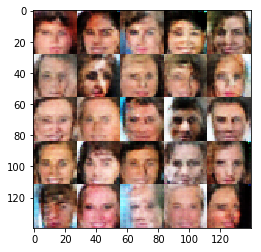

Epoch 4/5... Discriminator Loss: 1.4457... Generator Loss: 0.7663 Sum Loss: 2.2120
Epoch 4/5... Discriminator Loss: 1.3697... Generator Loss: 0.7970 Sum Loss: 2.1668
Epoch 4/5... Discriminator Loss: 1.3136... Generator Loss: 0.8142 Sum Loss: 2.1279
Epoch 4/5... Discriminator Loss: 1.3631... Generator Loss: 0.7873 Sum Loss: 2.1503
Epoch 4/5... Discriminator Loss: 1.3298... Generator Loss: 0.8236 Sum Loss: 2.1533
Epoch 4/5... Discriminator Loss: 1.3300... Generator Loss: 0.7914 Sum Loss: 2.1214
Epoch 4/5... Discriminator Loss: 1.3760... Generator Loss: 0.8055 Sum Loss: 2.1815
Epoch 4/5... Discriminator Loss: 1.3789... Generator Loss: 0.7602 Sum Loss: 2.1391
Epoch 4/5... Discriminator Loss: 1.3881... Generator Loss: 0.7752 Sum Loss: 2.1633
Epoch 4/5... Discriminator Loss: 1.3545... Generator Loss: 0.7876 Sum Loss: 2.1421


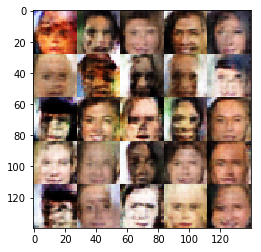

Epoch 4/5... Discriminator Loss: 1.3559... Generator Loss: 0.7956 Sum Loss: 2.1515
Epoch 4/5... Discriminator Loss: 1.3511... Generator Loss: 0.8110 Sum Loss: 2.1621
Epoch 4/5... Discriminator Loss: 1.3435... Generator Loss: 0.8201 Sum Loss: 2.1636
Epoch 4/5... Discriminator Loss: 1.2935... Generator Loss: 0.7996 Sum Loss: 2.0931
Epoch 4/5... Discriminator Loss: 1.3428... Generator Loss: 0.7714 Sum Loss: 2.1142
Epoch 4/5... Discriminator Loss: 1.4650... Generator Loss: 0.6146 Sum Loss: 2.0795
Epoch 4/5... Discriminator Loss: 1.3010... Generator Loss: 0.8594 Sum Loss: 2.1604
Epoch 4/5... Discriminator Loss: 1.4796... Generator Loss: 0.6665 Sum Loss: 2.1461
Epoch 4/5... Discriminator Loss: 1.3596... Generator Loss: 0.7592 Sum Loss: 2.1188
Epoch 4/5... Discriminator Loss: 1.4056... Generator Loss: 0.7712 Sum Loss: 2.1768


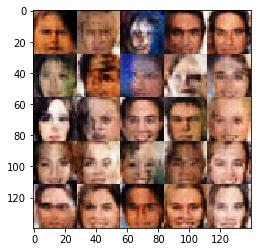

Epoch 4/5... Discriminator Loss: 1.3709... Generator Loss: 0.7920 Sum Loss: 2.1629
Epoch 4/5... Discriminator Loss: 1.3736... Generator Loss: 0.7733 Sum Loss: 2.1469
Epoch 4/5... Discriminator Loss: 1.3419... Generator Loss: 0.8192 Sum Loss: 2.1611
Epoch 4/5... Discriminator Loss: 1.3339... Generator Loss: 0.8071 Sum Loss: 2.1409
Epoch 4/5... Discriminator Loss: 1.3649... Generator Loss: 0.7831 Sum Loss: 2.1480
Epoch 4/5... Discriminator Loss: 1.3846... Generator Loss: 0.7880 Sum Loss: 2.1726
Epoch 4/5... Discriminator Loss: 1.2860... Generator Loss: 0.8119 Sum Loss: 2.0979
Epoch 4/5... Discriminator Loss: 1.3717... Generator Loss: 0.7873 Sum Loss: 2.1590
Epoch 4/5... Discriminator Loss: 1.3706... Generator Loss: 0.8081 Sum Loss: 2.1787
Epoch 4/5... Discriminator Loss: 1.3936... Generator Loss: 0.8069 Sum Loss: 2.2004


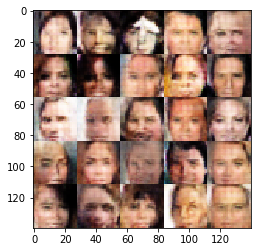

Epoch 4/5... Discriminator Loss: 1.3777... Generator Loss: 0.8171 Sum Loss: 2.1948
Epoch 4/5... Discriminator Loss: 1.3431... Generator Loss: 0.8032 Sum Loss: 2.1463
Epoch 4/5... Discriminator Loss: 1.3632... Generator Loss: 0.8002 Sum Loss: 2.1634
Epoch 4/5... Discriminator Loss: 1.3288... Generator Loss: 0.7837 Sum Loss: 2.1124
Epoch 4/5... Discriminator Loss: 1.3977... Generator Loss: 0.7536 Sum Loss: 2.1514
Epoch 4/5... Discriminator Loss: 1.2901... Generator Loss: 0.8304 Sum Loss: 2.1205
Epoch 4/5... Discriminator Loss: 1.3082... Generator Loss: 0.7889 Sum Loss: 2.0971
Epoch 4/5... Discriminator Loss: 1.4296... Generator Loss: 0.6731 Sum Loss: 2.1027
Epoch 4/5... Discriminator Loss: 1.3827... Generator Loss: 0.7589 Sum Loss: 2.1415
Epoch 4/5... Discriminator Loss: 1.3132... Generator Loss: 0.8029 Sum Loss: 2.1162


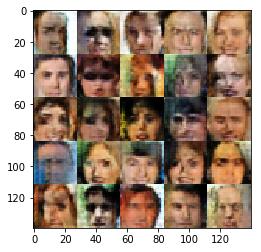

Epoch 4/5... Discriminator Loss: 1.3978... Generator Loss: 0.7906 Sum Loss: 2.1883
Epoch 4/5... Discriminator Loss: 1.3479... Generator Loss: 0.7941 Sum Loss: 2.1420
Epoch 4/5... Discriminator Loss: 1.3689... Generator Loss: 0.7785 Sum Loss: 2.1474
Epoch 4/5... Discriminator Loss: 1.4196... Generator Loss: 0.7671 Sum Loss: 2.1866
Epoch 4/5... Discriminator Loss: 1.3679... Generator Loss: 0.7818 Sum Loss: 2.1497
Epoch 4/5... Discriminator Loss: 1.3310... Generator Loss: 0.8248 Sum Loss: 2.1558
Epoch 4/5... Discriminator Loss: 1.4110... Generator Loss: 0.7475 Sum Loss: 2.1585
Epoch 4/5... Discriminator Loss: 1.3191... Generator Loss: 0.8383 Sum Loss: 2.1575
Epoch 4/5... Discriminator Loss: 1.3654... Generator Loss: 0.7820 Sum Loss: 2.1474
Epoch 4/5... Discriminator Loss: 1.3630... Generator Loss: 0.8061 Sum Loss: 2.1692


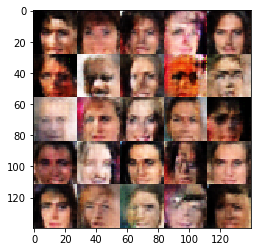

Epoch 4/5... Discriminator Loss: 1.2269... Generator Loss: 0.8649 Sum Loss: 2.0918
Epoch 4/5... Discriminator Loss: 1.3849... Generator Loss: 0.7930 Sum Loss: 2.1779
Epoch 4/5... Discriminator Loss: 1.3859... Generator Loss: 0.7593 Sum Loss: 2.1452
Epoch 4/5... Discriminator Loss: 1.3466... Generator Loss: 0.8380 Sum Loss: 2.1847
Epoch 4/5... Discriminator Loss: 1.3228... Generator Loss: 0.7992 Sum Loss: 2.1220
Epoch 4/5... Discriminator Loss: 1.3865... Generator Loss: 0.7803 Sum Loss: 2.1668
Epoch 4/5... Discriminator Loss: 1.3924... Generator Loss: 0.7796 Sum Loss: 2.1720
Epoch 4/5... Discriminator Loss: 1.3490... Generator Loss: 0.7818 Sum Loss: 2.1308
Epoch 4/5... Discriminator Loss: 1.3239... Generator Loss: 0.7868 Sum Loss: 2.1107
Epoch 4/5... Discriminator Loss: 1.3849... Generator Loss: 0.7680 Sum Loss: 2.1529


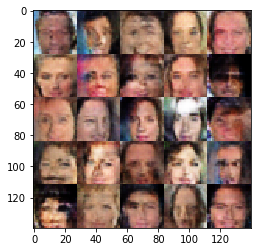

Epoch 4/5... Discriminator Loss: 1.3500... Generator Loss: 0.7896 Sum Loss: 2.1396
Epoch 4/5... Discriminator Loss: 1.3687... Generator Loss: 0.7985 Sum Loss: 2.1673
Epoch 4/5... Discriminator Loss: 1.3628... Generator Loss: 0.8157 Sum Loss: 2.1785
Epoch 4/5... Discriminator Loss: 1.3160... Generator Loss: 0.7828 Sum Loss: 2.0989
Epoch 4/5... Discriminator Loss: 1.4613... Generator Loss: 0.7236 Sum Loss: 2.1848
Epoch 4/5... Discriminator Loss: 1.3651... Generator Loss: 0.7735 Sum Loss: 2.1385
Epoch 4/5... Discriminator Loss: 1.3349... Generator Loss: 0.7850 Sum Loss: 2.1200
Epoch 4/5... Discriminator Loss: 1.3767... Generator Loss: 0.7608 Sum Loss: 2.1375
Epoch 4/5... Discriminator Loss: 1.3425... Generator Loss: 0.7751 Sum Loss: 2.1176
Epoch 4/5... Discriminator Loss: 1.4391... Generator Loss: 0.7592 Sum Loss: 2.1982


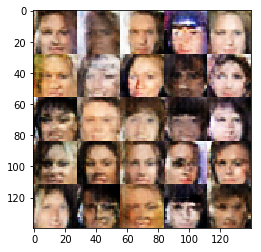

Epoch 4/5... Discriminator Loss: 1.4122... Generator Loss: 0.7970 Sum Loss: 2.2092
Epoch 4/5... Discriminator Loss: 1.3454... Generator Loss: 0.7789 Sum Loss: 2.1242
Epoch 4/5... Discriminator Loss: 1.3915... Generator Loss: 0.7799 Sum Loss: 2.1714
Epoch 4/5... Discriminator Loss: 1.3548... Generator Loss: 0.7766 Sum Loss: 2.1314
Epoch 4/5... Discriminator Loss: 1.3686... Generator Loss: 0.7882 Sum Loss: 2.1568
Epoch 4/5... Discriminator Loss: 1.3283... Generator Loss: 0.8025 Sum Loss: 2.1308
Epoch 4/5... Discriminator Loss: 1.3934... Generator Loss: 0.7965 Sum Loss: 2.1899
Epoch 4/5... Discriminator Loss: 1.2561... Generator Loss: 0.8332 Sum Loss: 2.0893
Epoch 4/5... Discriminator Loss: 1.3790... Generator Loss: 0.7411 Sum Loss: 2.1201
Epoch 4/5... Discriminator Loss: 1.3466... Generator Loss: 0.8433 Sum Loss: 2.1899


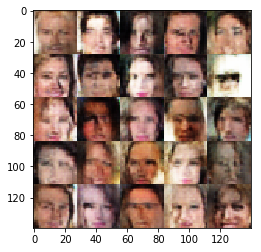

Epoch 4/5... Discriminator Loss: 1.3554... Generator Loss: 0.7536 Sum Loss: 2.1090
Epoch 4/5... Discriminator Loss: 1.3568... Generator Loss: 0.7623 Sum Loss: 2.1191
Epoch 4/5... Discriminator Loss: 1.3349... Generator Loss: 0.7805 Sum Loss: 2.1154
Epoch 4/5... Discriminator Loss: 1.2965... Generator Loss: 0.8339 Sum Loss: 2.1304
Epoch 4/5... Discriminator Loss: 1.3054... Generator Loss: 0.8160 Sum Loss: 2.1214
Epoch 4/5... Discriminator Loss: 1.3255... Generator Loss: 0.8219 Sum Loss: 2.1474
Epoch 4/5... Discriminator Loss: 1.3257... Generator Loss: 0.8072 Sum Loss: 2.1330
Epoch 4/5... Discriminator Loss: 1.3747... Generator Loss: 0.7911 Sum Loss: 2.1659
Epoch 4/5... Discriminator Loss: 1.4226... Generator Loss: 0.7557 Sum Loss: 2.1782
Epoch 4/5... Discriminator Loss: 1.3860... Generator Loss: 0.7826 Sum Loss: 2.1686


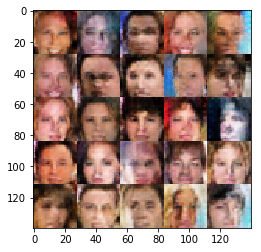

Epoch 4/5... Discriminator Loss: 1.3977... Generator Loss: 0.7785 Sum Loss: 2.1761
Epoch 4/5... Discriminator Loss: 1.3295... Generator Loss: 0.7584 Sum Loss: 2.0879
Epoch 4/5... Discriminator Loss: 1.3068... Generator Loss: 0.8065 Sum Loss: 2.1133
Epoch 4/5... Discriminator Loss: 1.4155... Generator Loss: 0.8255 Sum Loss: 2.2409
Epoch 4/5... Discriminator Loss: 1.3156... Generator Loss: 0.7757 Sum Loss: 2.0913
Epoch 4/5... Discriminator Loss: 1.3476... Generator Loss: 0.7960 Sum Loss: 2.1436
Epoch 4/5... Discriminator Loss: 1.3149... Generator Loss: 0.8175 Sum Loss: 2.1324
Epoch 4/5... Discriminator Loss: 1.2896... Generator Loss: 0.8119 Sum Loss: 2.1015
Epoch 4/5... Discriminator Loss: 1.4617... Generator Loss: 0.7979 Sum Loss: 2.2596
Epoch 4/5... Discriminator Loss: 1.3760... Generator Loss: 0.8031 Sum Loss: 2.1791


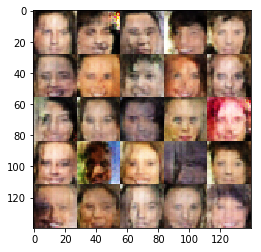

Epoch 4/5... Discriminator Loss: 1.4390... Generator Loss: 0.7791 Sum Loss: 2.2181
Epoch 4/5... Discriminator Loss: 1.3014... Generator Loss: 0.8301 Sum Loss: 2.1315
Epoch 4/5... Discriminator Loss: 1.3707... Generator Loss: 0.8455 Sum Loss: 2.2162
Epoch 4/5... Discriminator Loss: 1.4039... Generator Loss: 0.7059 Sum Loss: 2.1098
Epoch 4/5... Discriminator Loss: 1.3902... Generator Loss: 0.7691 Sum Loss: 2.1593
Epoch 4/5... Discriminator Loss: 1.4579... Generator Loss: 0.7633 Sum Loss: 2.2212
Epoch 4/5... Discriminator Loss: 1.3615... Generator Loss: 0.7981 Sum Loss: 2.1596
Epoch 4/5... Discriminator Loss: 1.3774... Generator Loss: 0.7909 Sum Loss: 2.1683
Epoch 4/5... Discriminator Loss: 1.4285... Generator Loss: 0.7261 Sum Loss: 2.1546
Epoch 4/5... Discriminator Loss: 1.3763... Generator Loss: 0.7520 Sum Loss: 2.1282


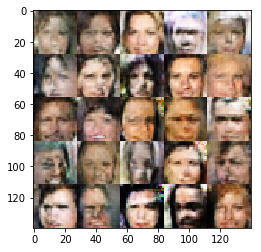

Epoch 4/5... Discriminator Loss: 1.3550... Generator Loss: 0.7638 Sum Loss: 2.1188
Epoch 4/5... Discriminator Loss: 1.3708... Generator Loss: 0.8137 Sum Loss: 2.1845
Epoch 4/5... Discriminator Loss: 1.3260... Generator Loss: 0.8003 Sum Loss: 2.1264
Epoch 4/5... Discriminator Loss: 1.3874... Generator Loss: 0.8045 Sum Loss: 2.1919
Epoch 4/5... Discriminator Loss: 1.3393... Generator Loss: 0.8064 Sum Loss: 2.1456
Epoch 4/5... Discriminator Loss: 1.3584... Generator Loss: 0.7727 Sum Loss: 2.1311
Epoch 4/5... Discriminator Loss: 1.3347... Generator Loss: 0.8279 Sum Loss: 2.1625
Epoch 4/5... Discriminator Loss: 1.4459... Generator Loss: 0.7028 Sum Loss: 2.1487
Epoch 4/5... Discriminator Loss: 1.3586... Generator Loss: 0.8244 Sum Loss: 2.1831
Epoch 4/5... Discriminator Loss: 1.3657... Generator Loss: 0.7824 Sum Loss: 2.1481


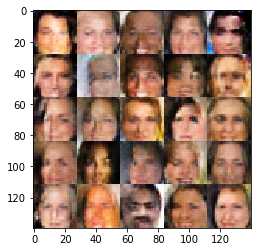

Epoch 4/5... Discriminator Loss: 1.3761... Generator Loss: 0.7905 Sum Loss: 2.1666
Epoch 4/5... Discriminator Loss: 1.3456... Generator Loss: 0.7808 Sum Loss: 2.1265
Epoch 4/5... Discriminator Loss: 1.3392... Generator Loss: 0.8248 Sum Loss: 2.1639
Epoch 4/5... Discriminator Loss: 1.3535... Generator Loss: 0.8076 Sum Loss: 2.1611
Epoch 4/5... Discriminator Loss: 1.3825... Generator Loss: 0.7969 Sum Loss: 2.1794
Epoch 4/5... Discriminator Loss: 1.3870... Generator Loss: 0.7753 Sum Loss: 2.1623
Epoch 4/5... Discriminator Loss: 1.3964... Generator Loss: 0.7717 Sum Loss: 2.1681
Epoch 5/5... Discriminator Loss: 1.2925... Generator Loss: 0.8133 Sum Loss: 2.1059
Epoch 5/5... Discriminator Loss: 1.3310... Generator Loss: 0.8217 Sum Loss: 2.1527
Epoch 5/5... Discriminator Loss: 1.3072... Generator Loss: 0.8161 Sum Loss: 2.1233


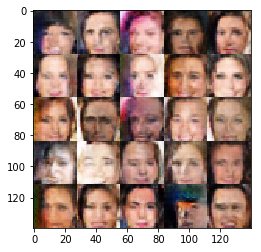

Epoch 5/5... Discriminator Loss: 1.3782... Generator Loss: 0.8052 Sum Loss: 2.1834
Epoch 5/5... Discriminator Loss: 1.4973... Generator Loss: 0.6968 Sum Loss: 2.1941
Epoch 5/5... Discriminator Loss: 1.3819... Generator Loss: 0.7565 Sum Loss: 2.1384
Epoch 5/5... Discriminator Loss: 1.3733... Generator Loss: 0.7724 Sum Loss: 2.1458
Epoch 5/5... Discriminator Loss: 1.3456... Generator Loss: 0.8052 Sum Loss: 2.1508
Epoch 5/5... Discriminator Loss: 1.3873... Generator Loss: 0.7322 Sum Loss: 2.1196
Epoch 5/5... Discriminator Loss: 1.3622... Generator Loss: 0.7996 Sum Loss: 2.1618
Epoch 5/5... Discriminator Loss: 1.3111... Generator Loss: 0.8350 Sum Loss: 2.1462
Epoch 5/5... Discriminator Loss: 1.3452... Generator Loss: 0.8045 Sum Loss: 2.1497
Epoch 5/5... Discriminator Loss: 1.3415... Generator Loss: 0.8012 Sum Loss: 2.1427


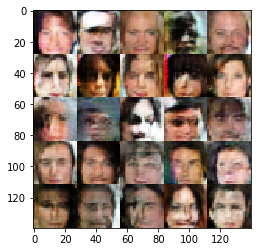

Epoch 5/5... Discriminator Loss: 1.3734... Generator Loss: 0.7851 Sum Loss: 2.1585
Epoch 5/5... Discriminator Loss: 1.4524... Generator Loss: 0.7305 Sum Loss: 2.1828
Epoch 5/5... Discriminator Loss: 1.3826... Generator Loss: 0.7598 Sum Loss: 2.1425
Epoch 5/5... Discriminator Loss: 1.2939... Generator Loss: 0.7894 Sum Loss: 2.0833
Epoch 5/5... Discriminator Loss: 1.3062... Generator Loss: 0.7961 Sum Loss: 2.1023
Epoch 5/5... Discriminator Loss: 1.3482... Generator Loss: 0.8408 Sum Loss: 2.1890
Epoch 5/5... Discriminator Loss: 1.3277... Generator Loss: 0.8297 Sum Loss: 2.1575
Epoch 5/5... Discriminator Loss: 1.3510... Generator Loss: 0.7939 Sum Loss: 2.1449
Epoch 5/5... Discriminator Loss: 1.3352... Generator Loss: 0.8110 Sum Loss: 2.1462
Epoch 5/5... Discriminator Loss: 1.3050... Generator Loss: 0.8168 Sum Loss: 2.1218


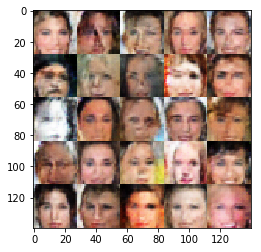

Epoch 5/5... Discriminator Loss: 1.3406... Generator Loss: 0.7747 Sum Loss: 2.1153
Epoch 5/5... Discriminator Loss: 1.3380... Generator Loss: 0.8247 Sum Loss: 2.1627
Epoch 5/5... Discriminator Loss: 1.3827... Generator Loss: 0.7477 Sum Loss: 2.1304
Epoch 5/5... Discriminator Loss: 1.3663... Generator Loss: 0.7614 Sum Loss: 2.1277
Epoch 5/5... Discriminator Loss: 1.3661... Generator Loss: 0.7798 Sum Loss: 2.1460
Epoch 5/5... Discriminator Loss: 1.3532... Generator Loss: 0.7635 Sum Loss: 2.1167
Epoch 5/5... Discriminator Loss: 1.3142... Generator Loss: 0.8096 Sum Loss: 2.1238
Epoch 5/5... Discriminator Loss: 1.3993... Generator Loss: 0.7807 Sum Loss: 2.1800
Epoch 5/5... Discriminator Loss: 1.4156... Generator Loss: 0.7000 Sum Loss: 2.1156
Epoch 5/5... Discriminator Loss: 1.3391... Generator Loss: 0.8275 Sum Loss: 2.1666


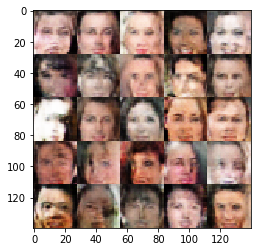

Epoch 5/5... Discriminator Loss: 1.3876... Generator Loss: 0.8247 Sum Loss: 2.2122
Epoch 5/5... Discriminator Loss: 1.4377... Generator Loss: 0.7254 Sum Loss: 2.1631
Epoch 5/5... Discriminator Loss: 1.3664... Generator Loss: 0.7867 Sum Loss: 2.1531
Epoch 5/5... Discriminator Loss: 1.3452... Generator Loss: 0.8302 Sum Loss: 2.1754
Epoch 5/5... Discriminator Loss: 1.3778... Generator Loss: 0.7677 Sum Loss: 2.1455
Epoch 5/5... Discriminator Loss: 1.3504... Generator Loss: 0.7833 Sum Loss: 2.1337
Epoch 5/5... Discriminator Loss: 1.3658... Generator Loss: 0.8341 Sum Loss: 2.1998
Epoch 5/5... Discriminator Loss: 1.3484... Generator Loss: 0.7765 Sum Loss: 2.1249
Epoch 5/5... Discriminator Loss: 1.3543... Generator Loss: 0.7818 Sum Loss: 2.1361
Epoch 5/5... Discriminator Loss: 1.3873... Generator Loss: 0.7103 Sum Loss: 2.0976


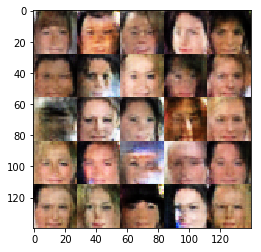

Epoch 5/5... Discriminator Loss: 1.3208... Generator Loss: 0.7656 Sum Loss: 2.0864
Epoch 5/5... Discriminator Loss: 1.3744... Generator Loss: 0.7615 Sum Loss: 2.1359
Epoch 5/5... Discriminator Loss: 1.3175... Generator Loss: 0.8264 Sum Loss: 2.1439
Epoch 5/5... Discriminator Loss: 1.2428... Generator Loss: 0.8900 Sum Loss: 2.1328
Epoch 5/5... Discriminator Loss: 1.3935... Generator Loss: 0.8024 Sum Loss: 2.1960
Epoch 5/5... Discriminator Loss: 1.3696... Generator Loss: 0.8213 Sum Loss: 2.1909
Epoch 5/5... Discriminator Loss: 1.3114... Generator Loss: 0.8280 Sum Loss: 2.1394
Epoch 5/5... Discriminator Loss: 1.3906... Generator Loss: 0.7488 Sum Loss: 2.1394
Epoch 5/5... Discriminator Loss: 1.4194... Generator Loss: 0.7743 Sum Loss: 2.1937
Epoch 5/5... Discriminator Loss: 1.3629... Generator Loss: 0.8365 Sum Loss: 2.1995


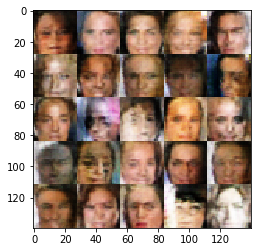

Epoch 5/5... Discriminator Loss: 1.3895... Generator Loss: 0.7620 Sum Loss: 2.1515
Epoch 5/5... Discriminator Loss: 1.3583... Generator Loss: 0.7964 Sum Loss: 2.1547
Epoch 5/5... Discriminator Loss: 1.3146... Generator Loss: 0.7778 Sum Loss: 2.0924
Epoch 5/5... Discriminator Loss: 1.3494... Generator Loss: 0.8063 Sum Loss: 2.1557
Epoch 5/5... Discriminator Loss: 1.2863... Generator Loss: 0.8511 Sum Loss: 2.1374
Epoch 5/5... Discriminator Loss: 1.3284... Generator Loss: 0.8393 Sum Loss: 2.1676
Epoch 5/5... Discriminator Loss: 1.4341... Generator Loss: 0.7686 Sum Loss: 2.2027
Epoch 5/5... Discriminator Loss: 1.3617... Generator Loss: 0.7606 Sum Loss: 2.1223
Epoch 5/5... Discriminator Loss: 1.2090... Generator Loss: 0.8615 Sum Loss: 2.0705
Epoch 5/5... Discriminator Loss: 1.3668... Generator Loss: 0.7764 Sum Loss: 2.1433


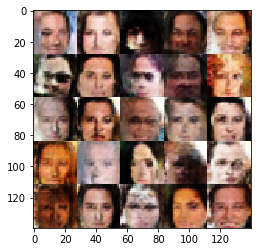

Epoch 5/5... Discriminator Loss: 1.3208... Generator Loss: 0.8235 Sum Loss: 2.1443
Epoch 5/5... Discriminator Loss: 1.3245... Generator Loss: 0.8005 Sum Loss: 2.1250
Epoch 5/5... Discriminator Loss: 1.3569... Generator Loss: 0.8073 Sum Loss: 2.1641
Epoch 5/5... Discriminator Loss: 1.3629... Generator Loss: 0.7955 Sum Loss: 2.1584
Epoch 5/5... Discriminator Loss: 1.3846... Generator Loss: 0.8030 Sum Loss: 2.1876
Epoch 5/5... Discriminator Loss: 1.3468... Generator Loss: 0.8289 Sum Loss: 2.1757
Epoch 5/5... Discriminator Loss: 1.3164... Generator Loss: 0.7953 Sum Loss: 2.1117
Epoch 5/5... Discriminator Loss: 1.3474... Generator Loss: 0.8095 Sum Loss: 2.1569
Epoch 5/5... Discriminator Loss: 1.3862... Generator Loss: 0.7342 Sum Loss: 2.1205
Epoch 5/5... Discriminator Loss: 1.3481... Generator Loss: 0.8044 Sum Loss: 2.1525


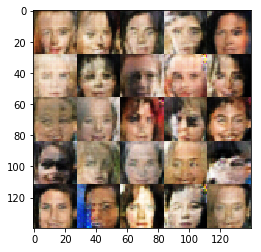

Epoch 5/5... Discriminator Loss: 1.4014... Generator Loss: 0.7235 Sum Loss: 2.1249
Epoch 5/5... Discriminator Loss: 1.2936... Generator Loss: 0.7940 Sum Loss: 2.0876
Epoch 5/5... Discriminator Loss: 1.3031... Generator Loss: 0.7821 Sum Loss: 2.0852
Epoch 5/5... Discriminator Loss: 1.3162... Generator Loss: 0.8056 Sum Loss: 2.1218
Epoch 5/5... Discriminator Loss: 1.3000... Generator Loss: 0.7933 Sum Loss: 2.0933
Epoch 5/5... Discriminator Loss: 1.3776... Generator Loss: 0.7766 Sum Loss: 2.1542
Epoch 5/5... Discriminator Loss: 1.3914... Generator Loss: 0.7906 Sum Loss: 2.1820
Epoch 5/5... Discriminator Loss: 1.3602... Generator Loss: 0.7756 Sum Loss: 2.1358
Epoch 5/5... Discriminator Loss: 1.3842... Generator Loss: 0.8368 Sum Loss: 2.2210
Epoch 5/5... Discriminator Loss: 1.3643... Generator Loss: 0.7701 Sum Loss: 2.1344


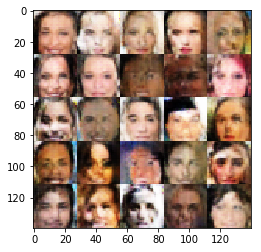

Epoch 5/5... Discriminator Loss: 1.3872... Generator Loss: 0.7653 Sum Loss: 2.1525
Epoch 5/5... Discriminator Loss: 1.3686... Generator Loss: 0.8318 Sum Loss: 2.2004
Epoch 5/5... Discriminator Loss: 1.3634... Generator Loss: 0.8659 Sum Loss: 2.2293
Epoch 5/5... Discriminator Loss: 1.3729... Generator Loss: 0.7794 Sum Loss: 2.1523
Epoch 5/5... Discriminator Loss: 1.3043... Generator Loss: 0.7740 Sum Loss: 2.0783
Epoch 5/5... Discriminator Loss: 1.4282... Generator Loss: 0.7419 Sum Loss: 2.1701
Epoch 5/5... Discriminator Loss: 1.3569... Generator Loss: 0.7871 Sum Loss: 2.1439
Epoch 5/5... Discriminator Loss: 1.3718... Generator Loss: 0.7208 Sum Loss: 2.0927
Epoch 5/5... Discriminator Loss: 1.3506... Generator Loss: 0.8202 Sum Loss: 2.1708
Epoch 5/5... Discriminator Loss: 1.3400... Generator Loss: 0.8089 Sum Loss: 2.1489


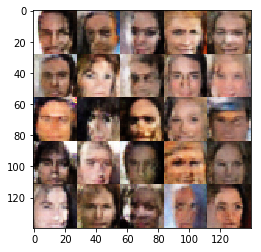

Epoch 5/5... Discriminator Loss: 1.2968... Generator Loss: 0.7784 Sum Loss: 2.0752
Epoch 5/5... Discriminator Loss: 1.3962... Generator Loss: 0.7989 Sum Loss: 2.1950
Epoch 5/5... Discriminator Loss: 1.3916... Generator Loss: 0.7433 Sum Loss: 2.1349
Epoch 5/5... Discriminator Loss: 1.3620... Generator Loss: 0.7749 Sum Loss: 2.1369
Epoch 5/5... Discriminator Loss: 1.3050... Generator Loss: 0.7867 Sum Loss: 2.0917
Epoch 5/5... Discriminator Loss: 1.3326... Generator Loss: 0.8007 Sum Loss: 2.1333
Epoch 5/5... Discriminator Loss: 1.3381... Generator Loss: 0.8170 Sum Loss: 2.1550
Epoch 5/5... Discriminator Loss: 1.3223... Generator Loss: 0.8011 Sum Loss: 2.1235
Epoch 5/5... Discriminator Loss: 1.3301... Generator Loss: 0.7994 Sum Loss: 2.1295
Epoch 5/5... Discriminator Loss: 1.3076... Generator Loss: 0.8024 Sum Loss: 2.1099


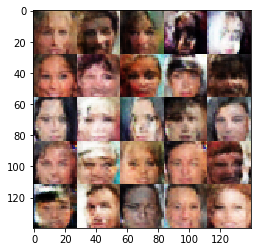

Epoch 5/5... Discriminator Loss: 1.4112... Generator Loss: 0.7559 Sum Loss: 2.1671
Epoch 5/5... Discriminator Loss: 1.3256... Generator Loss: 0.8035 Sum Loss: 2.1291
Epoch 5/5... Discriminator Loss: 1.3728... Generator Loss: 0.7959 Sum Loss: 2.1687
Epoch 5/5... Discriminator Loss: 1.3442... Generator Loss: 0.8305 Sum Loss: 2.1747
Epoch 5/5... Discriminator Loss: 1.3661... Generator Loss: 0.7735 Sum Loss: 2.1396
Epoch 5/5... Discriminator Loss: 1.2990... Generator Loss: 0.8194 Sum Loss: 2.1184
Epoch 5/5... Discriminator Loss: 1.3902... Generator Loss: 0.7466 Sum Loss: 2.1367
Epoch 5/5... Discriminator Loss: 1.3358... Generator Loss: 0.7700 Sum Loss: 2.1057
Epoch 5/5... Discriminator Loss: 1.3534... Generator Loss: 0.7663 Sum Loss: 2.1197
Epoch 5/5... Discriminator Loss: 1.3680... Generator Loss: 0.8012 Sum Loss: 2.1692


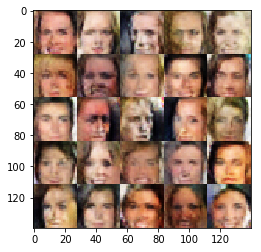

Epoch 5/5... Discriminator Loss: 1.3781... Generator Loss: 0.7777 Sum Loss: 2.1558
Epoch 5/5... Discriminator Loss: 1.3397... Generator Loss: 0.8170 Sum Loss: 2.1567
Epoch 5/5... Discriminator Loss: 1.3203... Generator Loss: 0.8147 Sum Loss: 2.1351
Epoch 5/5... Discriminator Loss: 1.4155... Generator Loss: 0.7620 Sum Loss: 2.1775
Epoch 5/5... Discriminator Loss: 1.2908... Generator Loss: 0.8388 Sum Loss: 2.1295
Epoch 5/5... Discriminator Loss: 1.2931... Generator Loss: 0.8309 Sum Loss: 2.1240
Epoch 5/5... Discriminator Loss: 1.4041... Generator Loss: 0.7470 Sum Loss: 2.1511
Epoch 5/5... Discriminator Loss: 1.2863... Generator Loss: 0.7657 Sum Loss: 2.0520
Epoch 5/5... Discriminator Loss: 1.4170... Generator Loss: 0.7535 Sum Loss: 2.1706
Epoch 5/5... Discriminator Loss: 1.2590... Generator Loss: 0.8447 Sum Loss: 2.1037


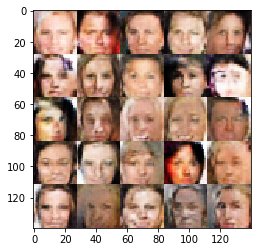

Epoch 5/5... Discriminator Loss: 1.3586... Generator Loss: 0.7610 Sum Loss: 2.1196
Epoch 5/5... Discriminator Loss: 1.3205... Generator Loss: 0.8002 Sum Loss: 2.1207
Epoch 5/5... Discriminator Loss: 1.4295... Generator Loss: 0.7979 Sum Loss: 2.2274
Epoch 5/5... Discriminator Loss: 1.3385... Generator Loss: 0.7906 Sum Loss: 2.1291
Epoch 5/5... Discriminator Loss: 1.3755... Generator Loss: 0.8364 Sum Loss: 2.2119
Epoch 5/5... Discriminator Loss: 1.1761... Generator Loss: 0.8445 Sum Loss: 2.0206
Epoch 5/5... Discriminator Loss: 1.3515... Generator Loss: 0.8224 Sum Loss: 2.1739
Epoch 5/5... Discriminator Loss: 1.2487... Generator Loss: 0.8623 Sum Loss: 2.1110
Epoch 5/5... Discriminator Loss: 1.3118... Generator Loss: 0.8117 Sum Loss: 2.1235
Epoch 5/5... Discriminator Loss: 1.3829... Generator Loss: 0.7929 Sum Loss: 2.1758


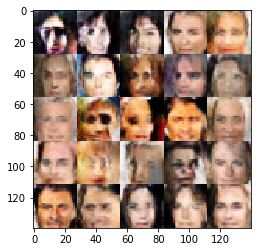

Epoch 5/5... Discriminator Loss: 1.3496... Generator Loss: 0.8478 Sum Loss: 2.1974
Epoch 5/5... Discriminator Loss: 1.3139... Generator Loss: 0.8522 Sum Loss: 2.1661
Epoch 5/5... Discriminator Loss: 1.3653... Generator Loss: 0.7990 Sum Loss: 2.1643
Epoch 5/5... Discriminator Loss: 1.2315... Generator Loss: 0.8487 Sum Loss: 2.0802
Epoch 5/5... Discriminator Loss: 1.3098... Generator Loss: 0.7754 Sum Loss: 2.0852
Epoch 5/5... Discriminator Loss: 1.3258... Generator Loss: 0.7886 Sum Loss: 2.1144
Epoch 5/5... Discriminator Loss: 1.3302... Generator Loss: 0.8125 Sum Loss: 2.1427
Epoch 5/5... Discriminator Loss: 1.3864... Generator Loss: 0.7545 Sum Loss: 2.1409
Epoch 5/5... Discriminator Loss: 1.3312... Generator Loss: 0.7931 Sum Loss: 2.1243
Epoch 5/5... Discriminator Loss: 1.3581... Generator Loss: 0.7513 Sum Loss: 2.1095


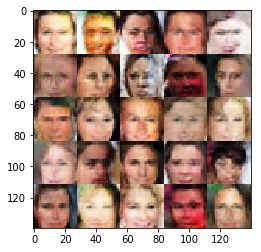

Epoch 5/5... Discriminator Loss: 1.2660... Generator Loss: 0.8400 Sum Loss: 2.1060
Epoch 5/5... Discriminator Loss: 1.3066... Generator Loss: 0.8421 Sum Loss: 2.1487
Epoch 5/5... Discriminator Loss: 1.2474... Generator Loss: 0.8426 Sum Loss: 2.0900
Epoch 5/5... Discriminator Loss: 1.3162... Generator Loss: 0.8362 Sum Loss: 2.1524
Epoch 5/5... Discriminator Loss: 1.3844... Generator Loss: 0.7008 Sum Loss: 2.0853
Epoch 5/5... Discriminator Loss: 1.4261... Generator Loss: 0.7695 Sum Loss: 2.1956
Epoch 5/5... Discriminator Loss: 1.3927... Generator Loss: 0.7878 Sum Loss: 2.1805
Epoch 5/5... Discriminator Loss: 1.2466... Generator Loss: 0.8371 Sum Loss: 2.0837
Epoch 5/5... Discriminator Loss: 1.2423... Generator Loss: 0.8885 Sum Loss: 2.1308


IndexError: list index out of range

In [41]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.